In [143]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import ast
import collections
import re
from collections import Counter
from datetime import datetime

## 1: Import sessions, logs, arks

In [22]:
arks_counts = pd.read_csv("arks_temp_month/final_arks_counts.csv")

In [3]:
# import logs (first and last batch, for size)
first_logs_df = pd.read_csv("data_temp_month/clean_logs0.csv", index_col=0)
last_logs_df = pd.read_csv("data_temp_month/clean_logs21.csv", index_col=0)
sessions_df = pd.read_csv("data_month/enriched_sessions.csv", index_col=0)
sessions_rh_df = pd.read_csv("data_month/rh_sessions.csv", index_col=0)
arks_dict = pd.read_csv('arks_final_month/arks_dict.csv', index_col=0)

In [170]:
sessions_df.to_csv("data_month/sesssions_complete.csv")
sessions_normal_df.to_csv("data_month/sessions_normal.csv")
sessions_rh_df.to_csv("data_month/sessions_rh_old.csv")

In [171]:
sessions_rh_df = sessions_rh_df[sessions_rh_df['length_minutes'] <= 300]

## 2: Statistics on the logs

We run a few statistics on the logs and on the arks.

In [4]:
first_date = first_logs_df['Date'].min()
last_date = last_logs_df['Date'].max()

In [5]:
print("We have logs from", first_date, "to", last_date)

We have logs from 2016-01-31 13:00:13+01:00 to 2016-02-29 05:36:46+01:00


In [6]:
# function  to calculate the percentage of a specific value in a column of a dataframe
# we will use it to get the number of unknown values of certain columns
def calculate_percentage(df, column, value):
    # count occurrences of the value in the column
    count_value = df[column].value_counts().get(value, 0)
    
    # if the value is NaN, count NaN values directly
    if pd.isna(value):
        count_value = df[column].isna().sum()
    
    # calculate percentage
    percentage = count_value / len(df) * 100
    
    return percentage

In [11]:
# percentage of unknown referrers
percentage_unknown_referrer_first = calculate_percentage(first_logs_df, 'Referrer', '-')
percentage_unknown_referrer_last = calculate_percentage(last_logs_df, 'Referrer', '-')
print("Percentage of unknown referrers: ", (percentage_unknown_referrer_first + percentage_unknown_referrer_last)/2)

Percentage of unknown referrers:  16.21274555365772


In [12]:
# convert string representations to actual lists
first_logs_df['search_terms'] = first_logs_df['search_terms'].apply(ast.literal_eval)
last_logs_df['search_terms'] = last_logs_df['search_terms'].apply(ast.literal_eval)

# count occurrences of empty lists in the 'search_terms' column
nb_non_search_first = (first_logs_df['search_terms'].apply(lambda x: len(x) == 0)).sum()
nb_non_search_last = (last_logs_df['search_terms'].apply(lambda x: len(x) == 0)).sum()

# get percentage of non-search request in all logs
percentage_non_search_first = nb_non_search_first/len(first_logs_df) * 100
percentage_non_search_last = nb_non_search_last/len(last_logs_df) * 100

print("Percentage of non-search requests : ", (percentage_non_search_first+percentage_non_search_last)/2)

Percentage of non-search requests :  98.32269342637665


We want to know the types and themes of the top 10% of most / least visible arks for rabbit holes and normal sessions.

In [13]:
# normal sessions : non RH ones
sessions_normal_df = sessions_df[~sessions_df.isin(sessions_rh_df.to_dict(orient='list')).all(axis=1)]

In [229]:
# a dictionnary to map the Dewey classes to the themes
dewey_subclasses = {
    944: "History of France",
    7: "Arts and Recreation",
    34: "Law",
    84: "French and related Literatures",
    35: "Public Administration",
    80: "Literature",
    61: "Medicine and Health",
    90: "Manuscripts and rare books",
    70: "News media, journalism and publishing",
    91: "Geography and Travel",
    50: "Magazines, journals and serials",
    94: "History of Europe",
    5: "General serial publications",
    6: "General organizations & museum science",
    93: "History of Ancient World",
    1: "Bibliography",
    32: "Political Science",
    92: "Biography, Genealogy, Insignia",
    33: "Economics",
    79: "Sports, games and entertainment",
    63: "Agriculture",
    51: "Mathematics",
    52: "Astronomy",
    306: "Culture and Institutions",
    55: "In Italian, Romanian and related languages",
    72: "Architecture",
    9: "Manuscripts and rare books",
    23: "Christianity and Christian Theology",
    49: "Other languages",
    17: "Ethics",
    82: "English and Old English Literatures",
    22: "Bible",
    3: "Encyclopedias and books of facts",
    66: "In Iberian Peninsula and adjacent islands",
    46: "Spanish and Portuguese languages",
    86: "Spanish and Portuguese literatures",
    76: "Graphic Arts",
    47: "Latin and Italic languages",
    25: "Christian pastoral practice and religious orders",
    15: "Psychology",
    75: "Painting",
    18: "Ancient, Medieval, and Eastern Philosophy",
    301: "Sociology and anthropology",
    95: "History of Asia",
    40: "Language",
    81: "American Literature in English",
    14: "Philosophical schools of thought",
    99: "History of Other Areas",
    31: "Statistics",
    83: "German and related Literatures",
    12: "Epistemology",
    56: "Serials in Spanish & Portuguese"
}
# source https://www.oclc.org/content/dam/oclc/dewey/resources/summaries/deweysummaries.pdf

In [230]:
# extract arks that are only in rabbit hole sessions
arks_in_rh_sessions = sessions_rh_df['Ark_list'].explode().dropna()

# convert the ARKs to a list
arks_list = arks_in_rh_sessions.tolist()

extracted_arks = []
for arks_string in arks_list:
    # remove leading and trailing square brackets and quotes, then split by comma and space
    arks = arks_string.strip("[]").replace("'", "").split(", ")
    # extend the extracted_arks list with the ARKs from the current string
    extracted_arks.extend(arks)


# get unique ARKs
unique_arks = set(extracted_arks)

# convert the unique ARKs to a list
unique_arks_list = list(unique_arks)

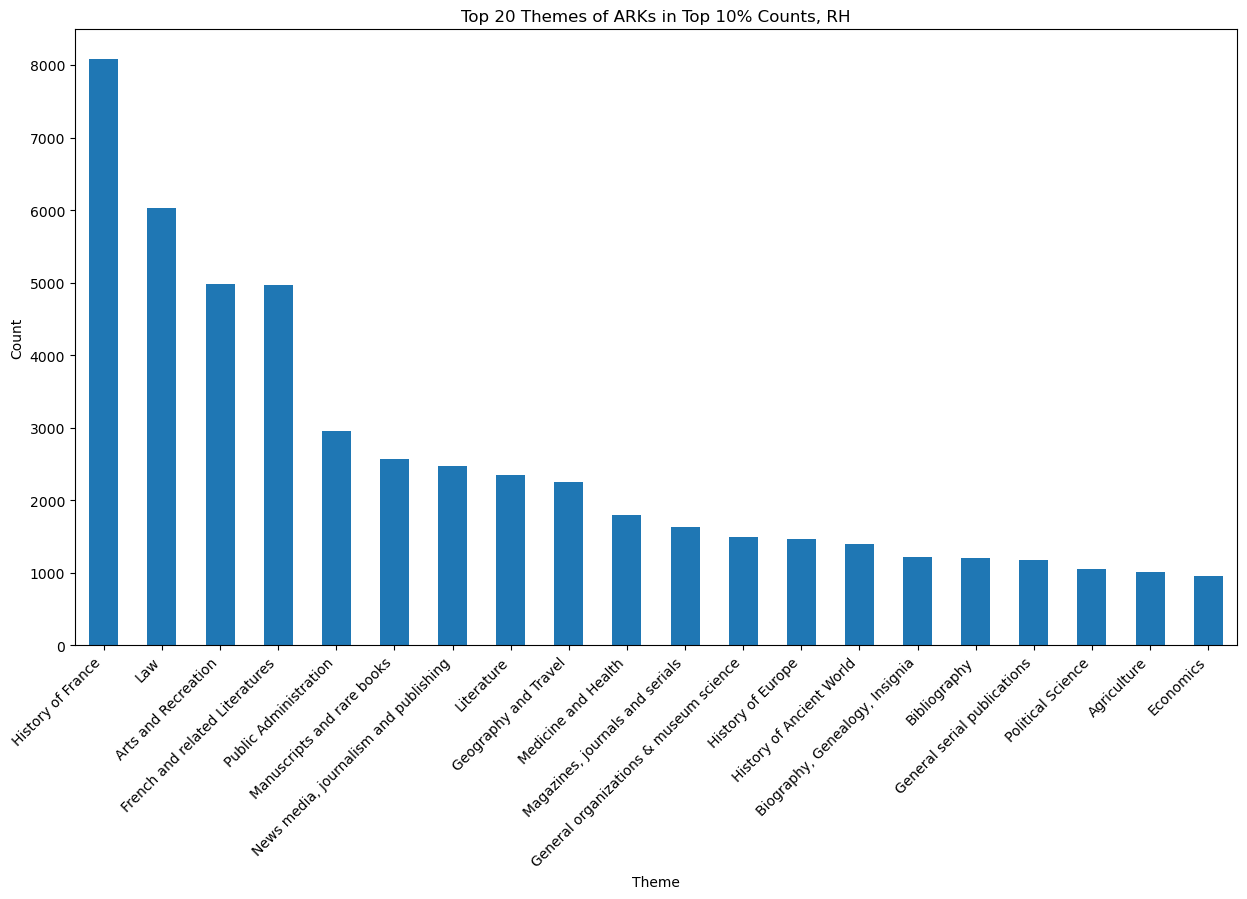

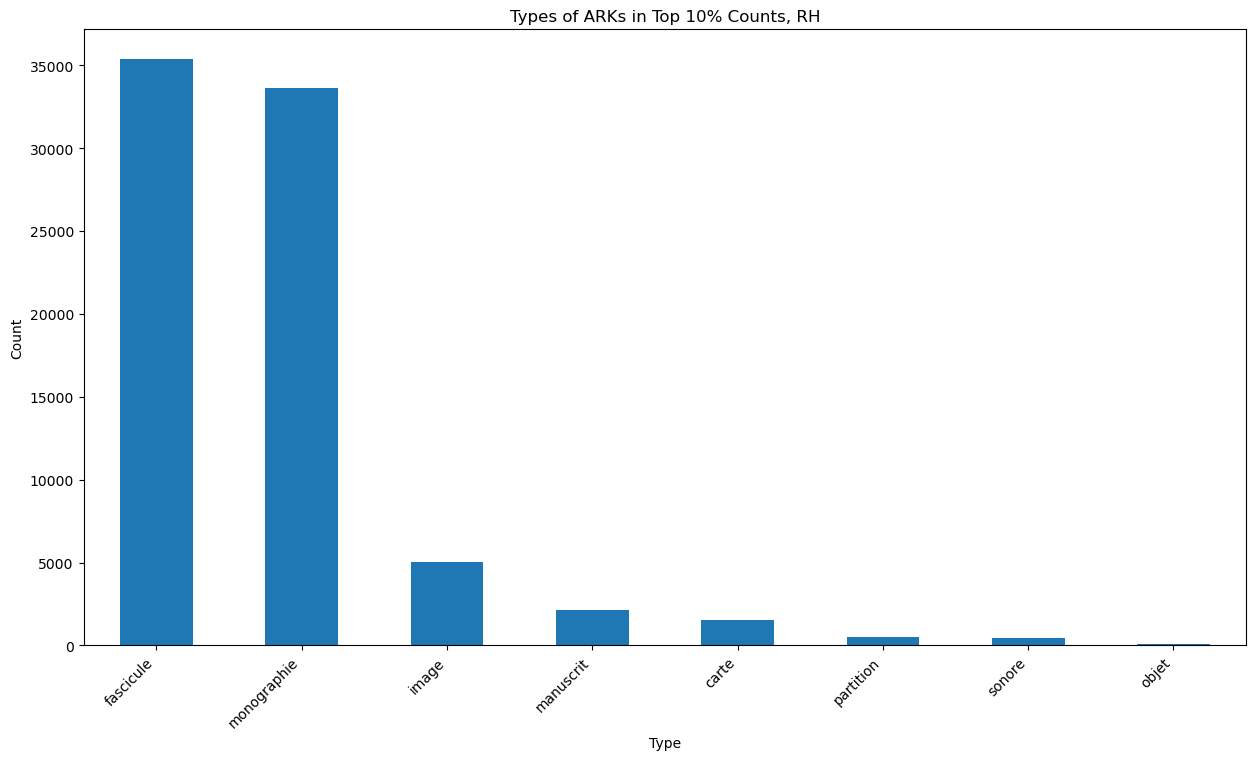

In [231]:
# filter arks_counts to include only ARKs present in rh sessions
filtered_arks_counts = arks_counts[arks_counts['Ark'].isin(unique_arks_list)]

# get the top 10% count threshold for filtered ARKs
top_10_percent_threshold = filtered_arks_counts['Count'].quantile(0.9)

# filter the ARKs in the top 10% counts
top_10_percent_arks = filtered_arks_counts[filtered_arks_counts['Count'] >= top_10_percent_threshold]

# retrieve types and themes for the top 10% ARKs from arks_dict DataFrame
top_10_percent_arks_info = pd.merge(top_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# map the themes to their Dewey themes
top_10_percent_arks_info['Dewey_Theme'] = top_10_percent_arks_info['Theme'].map(dewey_subclasses)

# filter the top 20 themes
top_20_themes = top_10_percent_arks_info['Theme'].value_counts().nlargest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
top_10_percent_arks_info[top_10_percent_arks_info['Theme'].isin(top_20_themes.index)]['Dewey_Theme'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Top 10% Counts, RH')
plt.savefig('plots/top_themes_most_vis_arks_rh.png', bbox_inches='tight')
plt.show()

# plot the types for the top 10% ARKs
plt.figure(figsize=(15, 8))
top_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Top 10% Counts, RH')
plt.savefig('plots/top_types_most_vis_arks_rh.png', bbox_inches='tight')
plt.show()


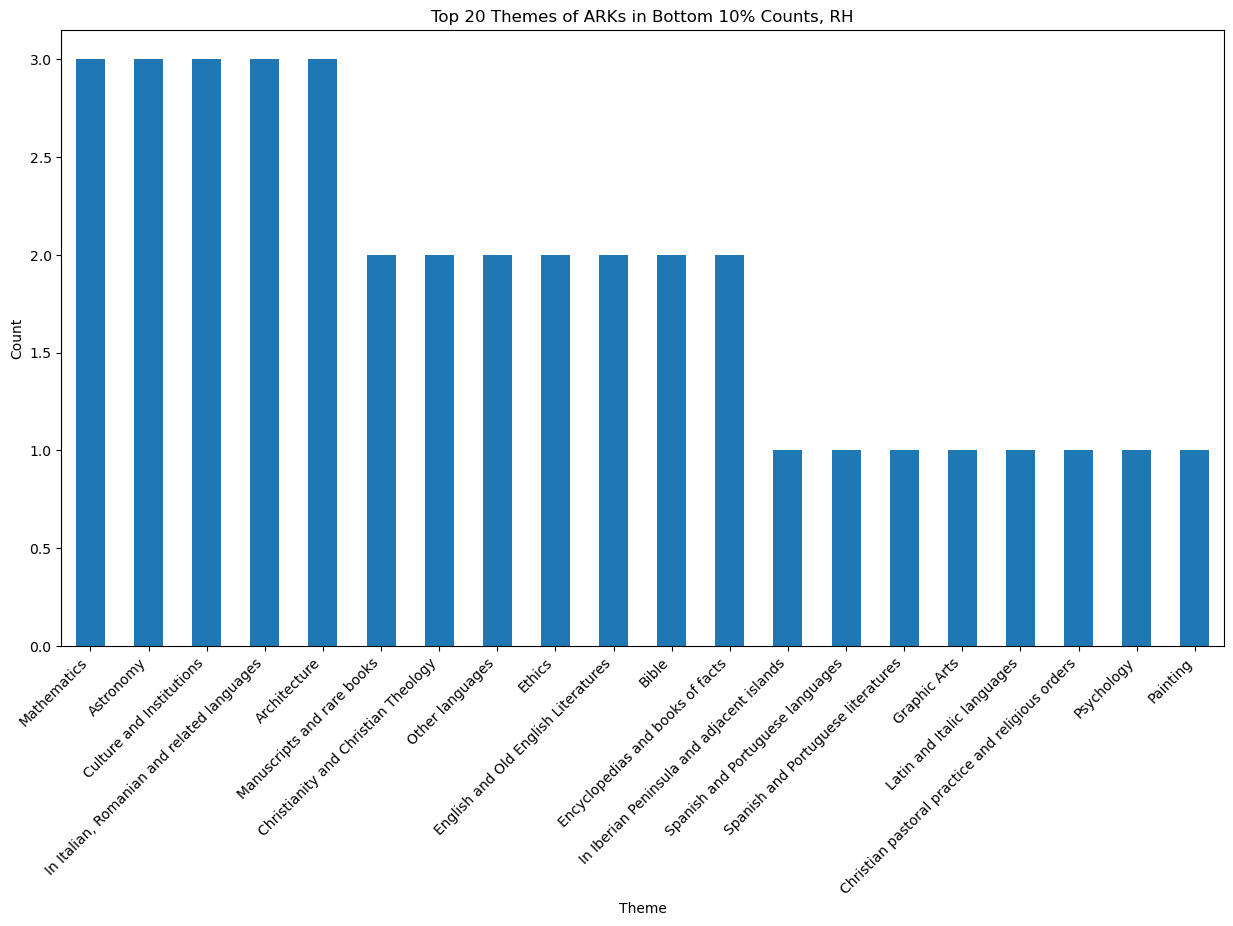

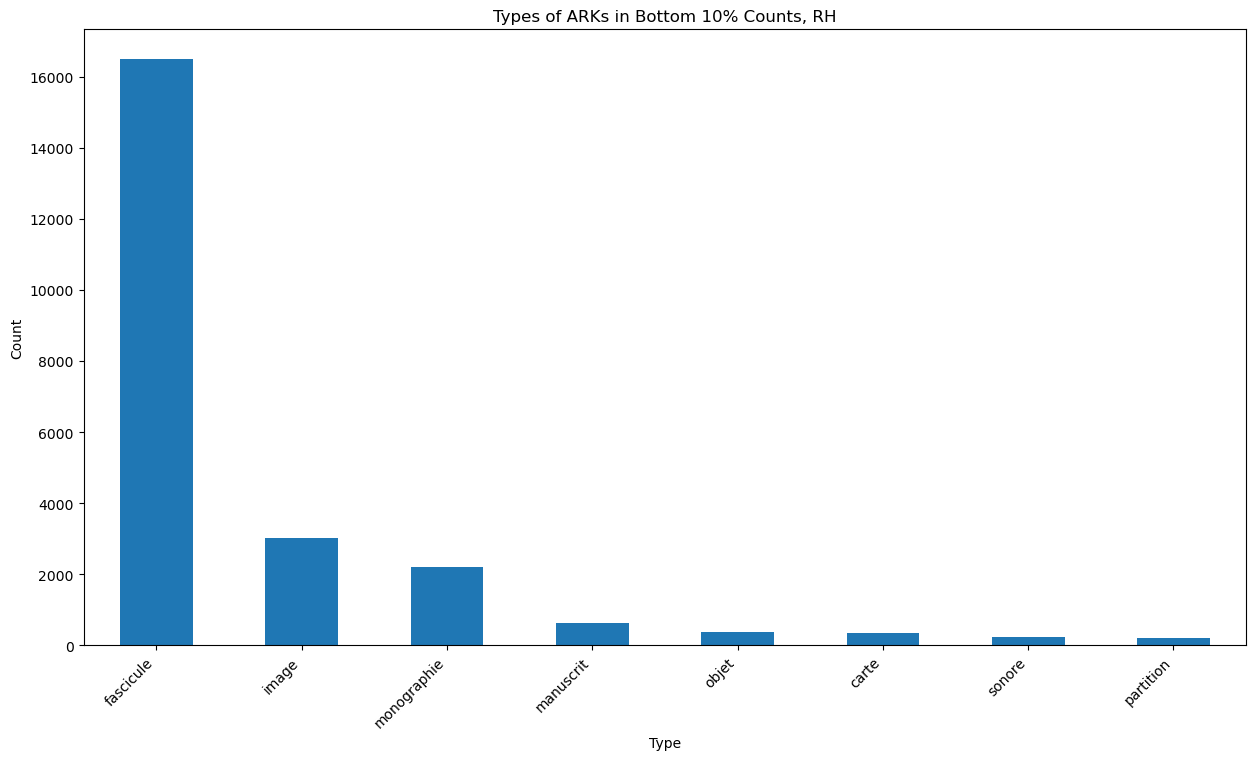

In [232]:
# get the bottom 10% count threshold for filtered ARKs
bottom_10_percent_threshold = filtered_arks_counts['Count'].quantile(0.1)

# filter the ARKs in the bottom 10% counts
bottom_10_percent_arks = filtered_arks_counts[filtered_arks_counts['Count'] <= bottom_10_percent_threshold]

# retrieve types and themes for the bottom 10% ARKs from arks_dict DataFrame
bottom_10_percent_arks_info = pd.merge(bottom_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# map the themes to their Dewey themes
bottom_10_percent_arks_info['Dewey_Theme'] = bottom_10_percent_arks_info['Theme'].map(dewey_subclasses)

# filter the top 20 themes
bottom_20_themes = bottom_10_percent_arks_info['Theme'].value_counts().nsmallest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info[bottom_10_percent_arks_info['Theme'].isin(bottom_20_themes.index)]['Dewey_Theme'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Bottom 10% Counts, RH')
plt.savefig('plots/top_themes_least_vis_arks_rh.png', bbox_inches='tight')
plt.show()

# plot the types for the bottom 10% ARKs
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Bottom 10% Counts, RH')
plt.savefig('plots/top_types_least_vis_arks_rh.png', bbox_inches='tight')
plt.show()


Same process for all sessions.

In [233]:
# extract arks that are only in normal sessions
arks_in_normal_sessions = sessions_normal_df['Ark_list'].explode().dropna()

# convert the ARKs to a list
arks_list = arks_in_normal_sessions.tolist()

extracted_arks = []
for arks_string in arks_list:
    # remove leading and trailing square brackets and quotes, then split by comma and space
    arks = arks_string.strip("[]").replace("'", "").split(", ")
    # extend the extracted_arks list with the ARKs from the current string
    extracted_arks.extend(arks)


# get unique ARKs
unique_arks = set(extracted_arks)

# convert the unique ARKs to a list
unique_arks_list = list(unique_arks)

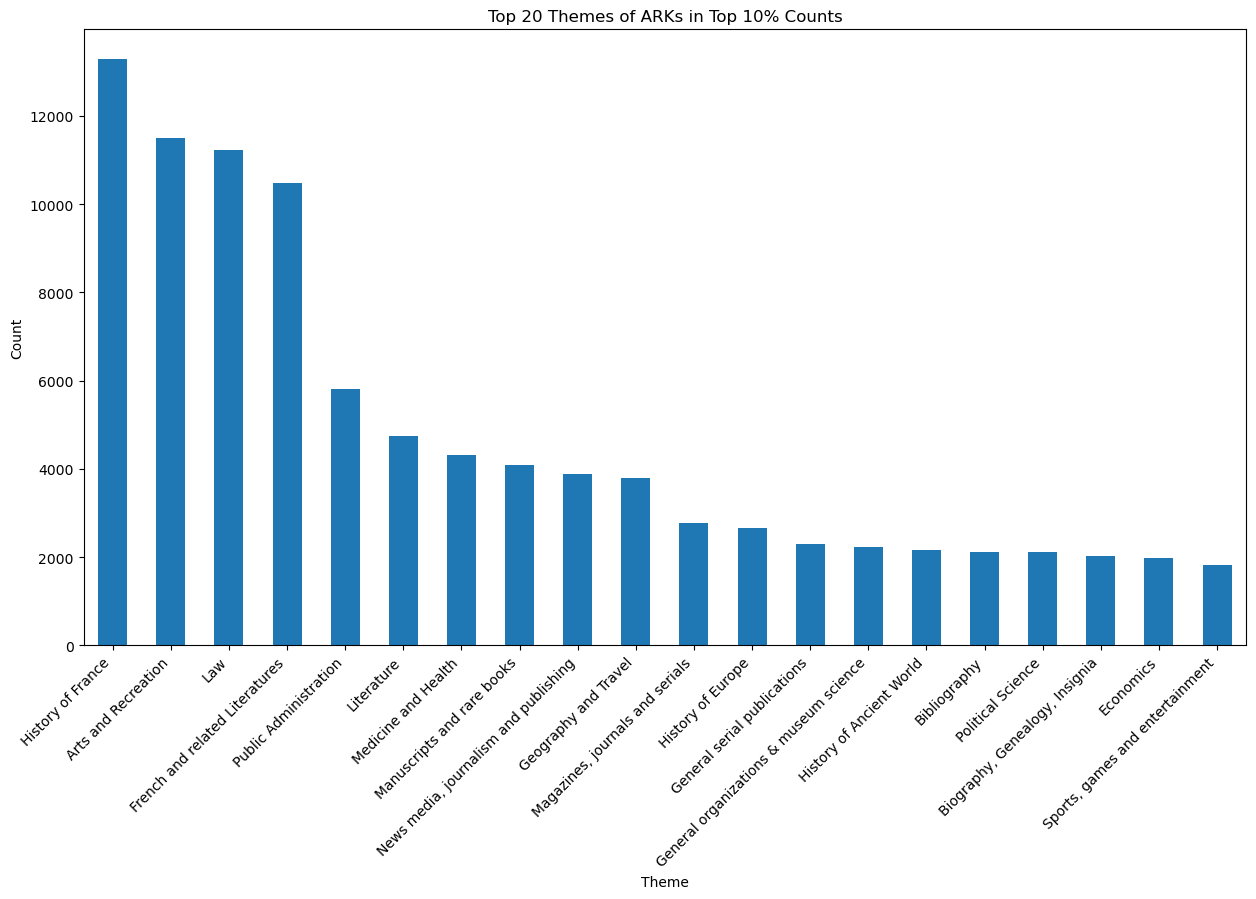

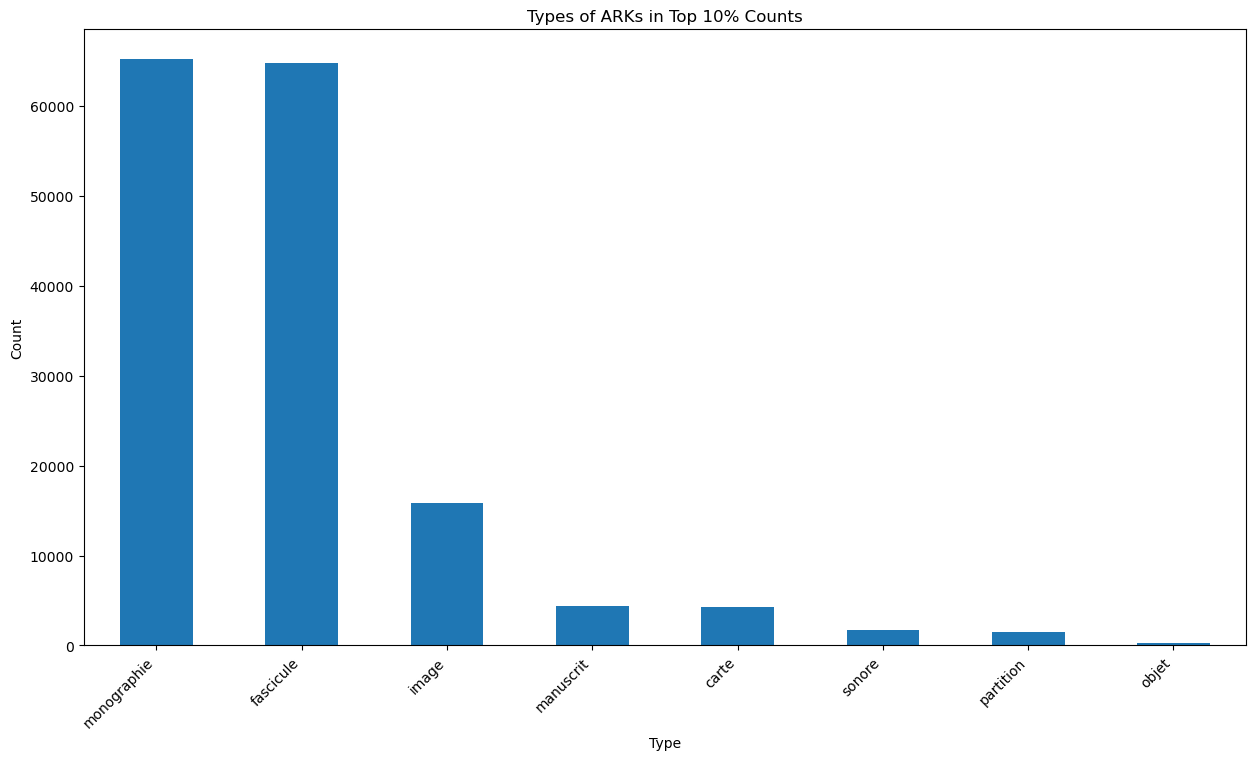

In [237]:
filtered_arks_counts = arks_counts[arks_counts['Ark'].isin(unique_arks_list)]

# calculate the top 10% count threshold
top_10_percent_threshold = filtered_arks_counts['Count'].quantile(0.9)

# filter the ARKs in the top 10% counts
top_10_percent_arks = filtered_arks_counts[filtered_arks_counts['Count'] >= top_10_percent_threshold]

# retrieve types and themes for the top 10% ARKs from arks_dict DataFrame
top_10_percent_arks_info = pd.merge(top_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# map the themes to their Dewey themes
top_10_percent_arks_info['Dewey_Theme'] = top_10_percent_arks_info['Theme'].map(dewey_subclasses)

# filter the top 20 themes
top_20_themes = top_10_percent_arks_info['Theme'].value_counts().nlargest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
top_10_percent_arks_info[top_10_percent_arks_info['Theme'].isin(top_20_themes.index)]['Dewey_Theme'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Top 10% Counts')
plt.savefig('plots/top_themes_most_vis_arks.png', bbox_inches='tight')
plt.show()


# plot the types for the top 10% ARKs
plt.figure(figsize=(15, 8))
top_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Top 10% Counts')
plt.savefig('plots/top_types_least_vis_arks.png', bbox_inches='tight')
plt.show()

944 : History and geography of France and regions, 7 : Arts, 34 : Droit, 84.0 : Littérature Française, 35.0 : Public administration and military science

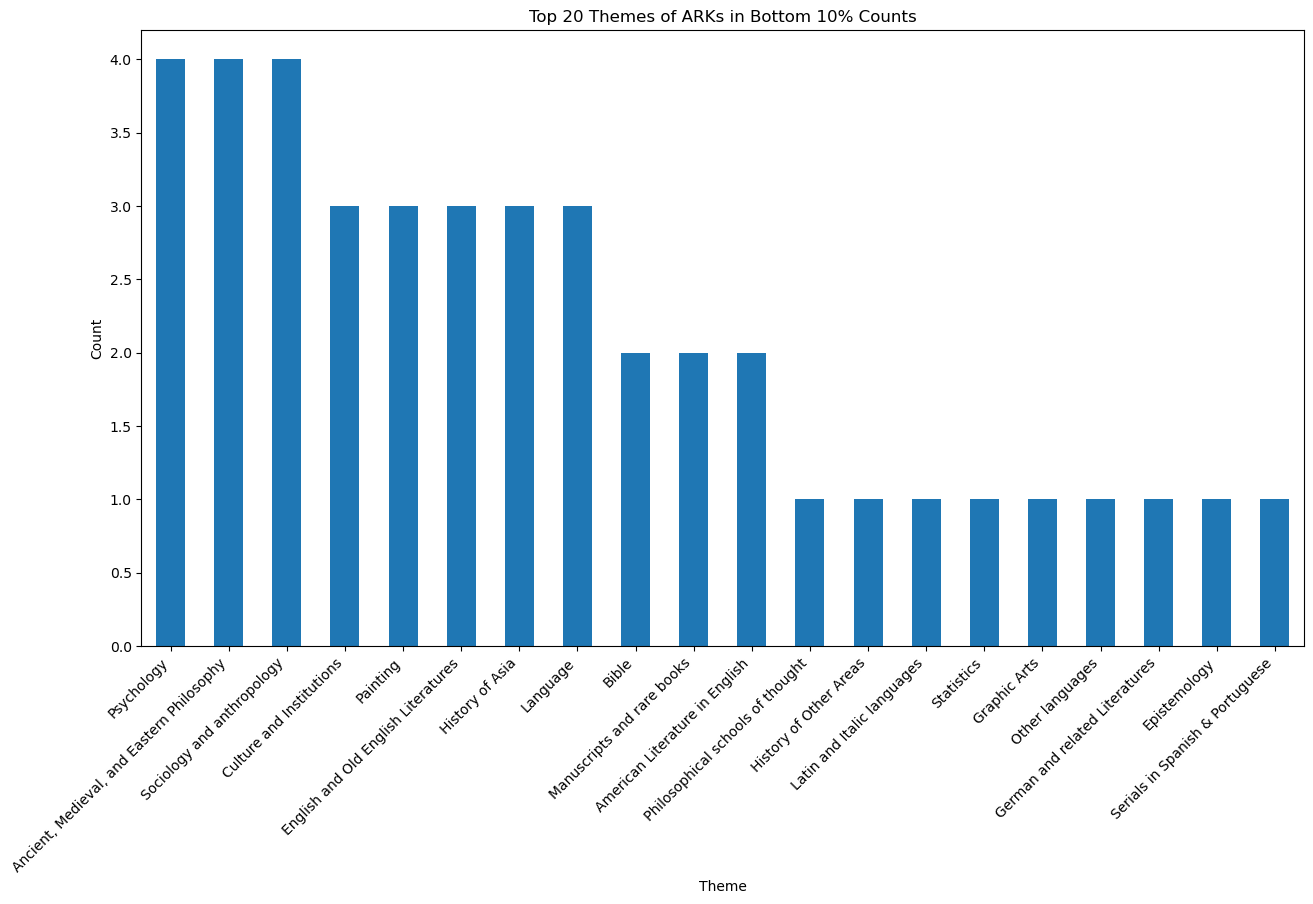

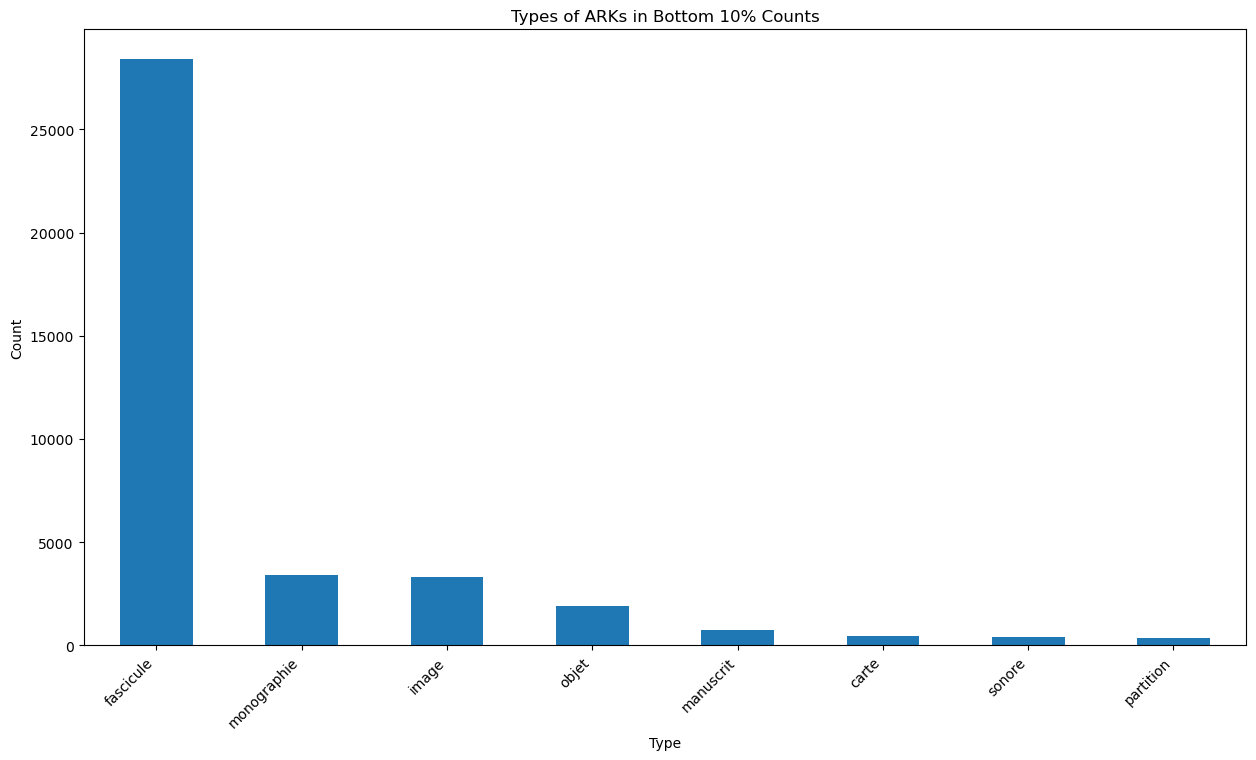

In [238]:
# calculate the bottom 10% count threshold
bottom_10_percent_threshold = filtered_arks_counts['Count'].quantile(0.1)

# filter the ARKs in the bottom 10% counts
bottom_10_percent_arks = filtered_arks_counts[filtered_arks_counts['Count'] <= bottom_10_percent_threshold]

# retrieve types and themes for the bottom 10% ARKs from arks_dict DataFrame
bottom_10_percent_arks_info = pd.merge(bottom_10_percent_arks, arks_dict, left_on='Ark', right_index=True, how='left')

# map the themes to their Dewey themes
bottom_10_percent_arks_info['Dewey_Theme'] = bottom_10_percent_arks_info['Theme'].map(dewey_subclasses)

# filter the top 20 themes
bottom_20_themes = bottom_10_percent_arks_info['Theme'].value_counts().nsmallest(20)

# plot the top 20 themes
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info[bottom_10_percent_arks_info['Theme'].isin(bottom_20_themes.index)]['Dewey_Theme'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Top 20 Themes of ARKs in Bottom 10% Counts')
plt.savefig('plots/top_themes_least_vis_arks.png', bbox_inches='tight')
plt.show()


# plot the types for the bottom 10% ARKs
plt.figure(figsize=(15, 8))
bottom_10_percent_arks_info['Type'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Types of ARKs in Bottom 10% Counts')
plt.savefig('plots/top_types_most_vis_arks.png', bbox_inches='tight')
plt.show()


18.0 : Ancient, Medieval and Eastern Philosophy, 40.0 : Language, 301.0 : Sociology and Anthropology, 24.0 : Christian Practice and Observance, 95.0 : History of Asia

## 3: Statistics on the sessions (RH and non RH)

We plot some statistics on the sessions, first the occurrences of search terms.

In [30]:
def extract_non_empty_terms(search_terms):
    # convert string representation of list to actual list
    search_terms_list = ast.literal_eval(search_terms)
    # filter out non-empty terms
    non_empty_terms = [term for term in search_terms_list if term != '[]']
    return non_empty_terms

In [33]:
search_terms_col = sessions_normal_df['search_terms']
non_empty_search_terms = [extract_non_empty_terms(term) for term in search_terms_col]

In [36]:
# flatten the list of lists
flat_search_terms = [term for sublist in non_empty_search_terms for term in sublist]


In [38]:
flat_search_terms = [ast.literal_eval(item)[0] for item in flat_search_terms]

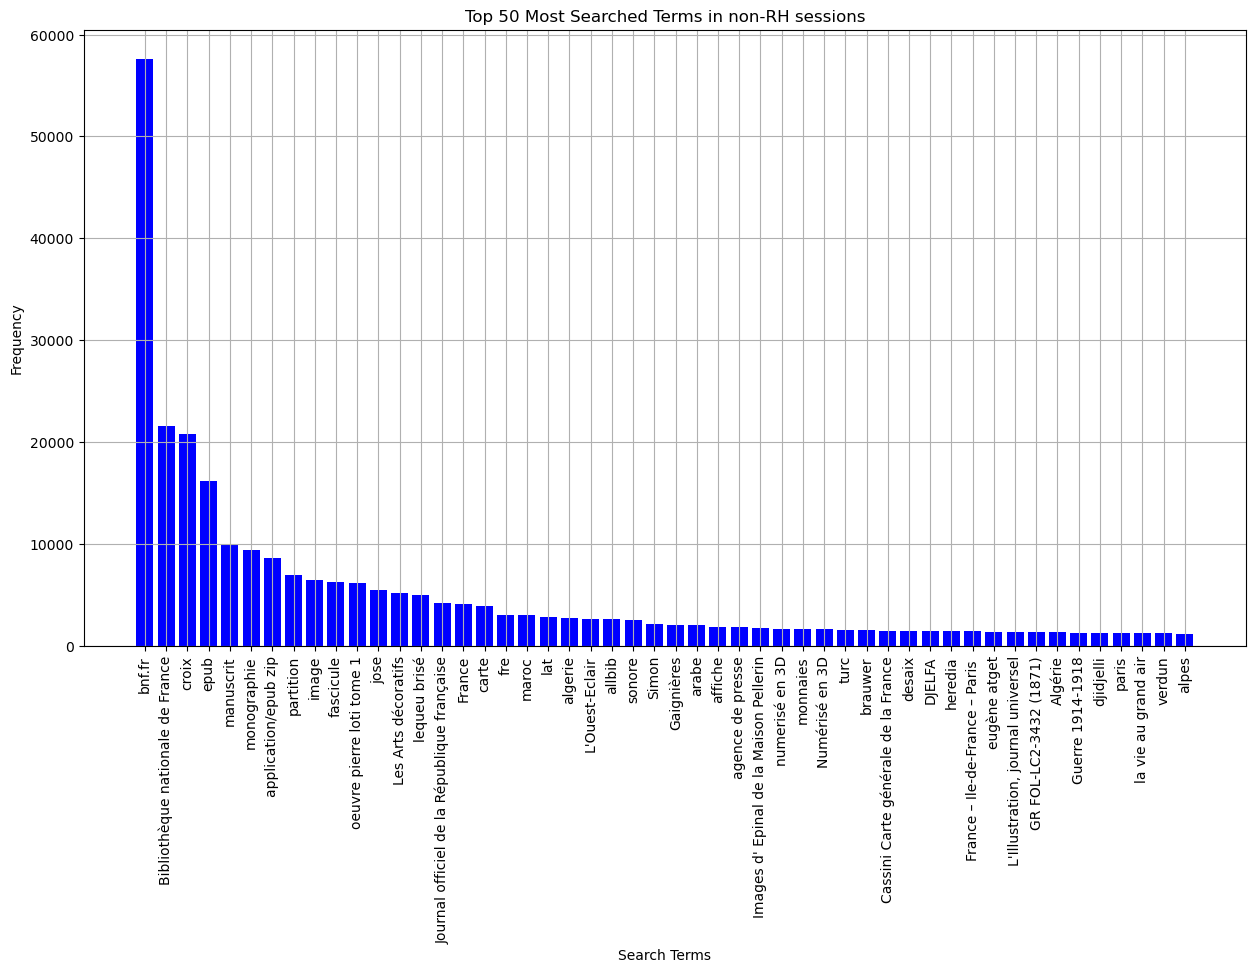

In [40]:
# count the frequency of each search term
term_counts = collections.Counter(flat_search_terms)

# get the 50 most frequent search terms
top_50_terms = term_counts.most_common(50)

# separate the terms and their counts for plotting
terms, counts = zip(*top_50_terms)

# visualize the results using a bar chart
plt.figure(figsize=(15, 8))
plt.bar(terms, counts, color='blue')
plt.xlabel('Search Terms')
plt.ylabel('Frequency')
plt.title('Top 50 Most Searched Terms in non-RH sessions')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig("plots/top50search.png")
plt.show()


Same for RH sessions.

In [176]:
search_terms_col_rh = sessions_rh_df['search_terms']
non_empty_search_terms_rh = [extract_non_empty_terms(term) for term in search_terms_col_rh]
flat_search_terms = [term for sublist in non_empty_search_terms_rh for term in sublist]
flat_search_terms = [ast.literal_eval(item)[0] for item in flat_search_terms]

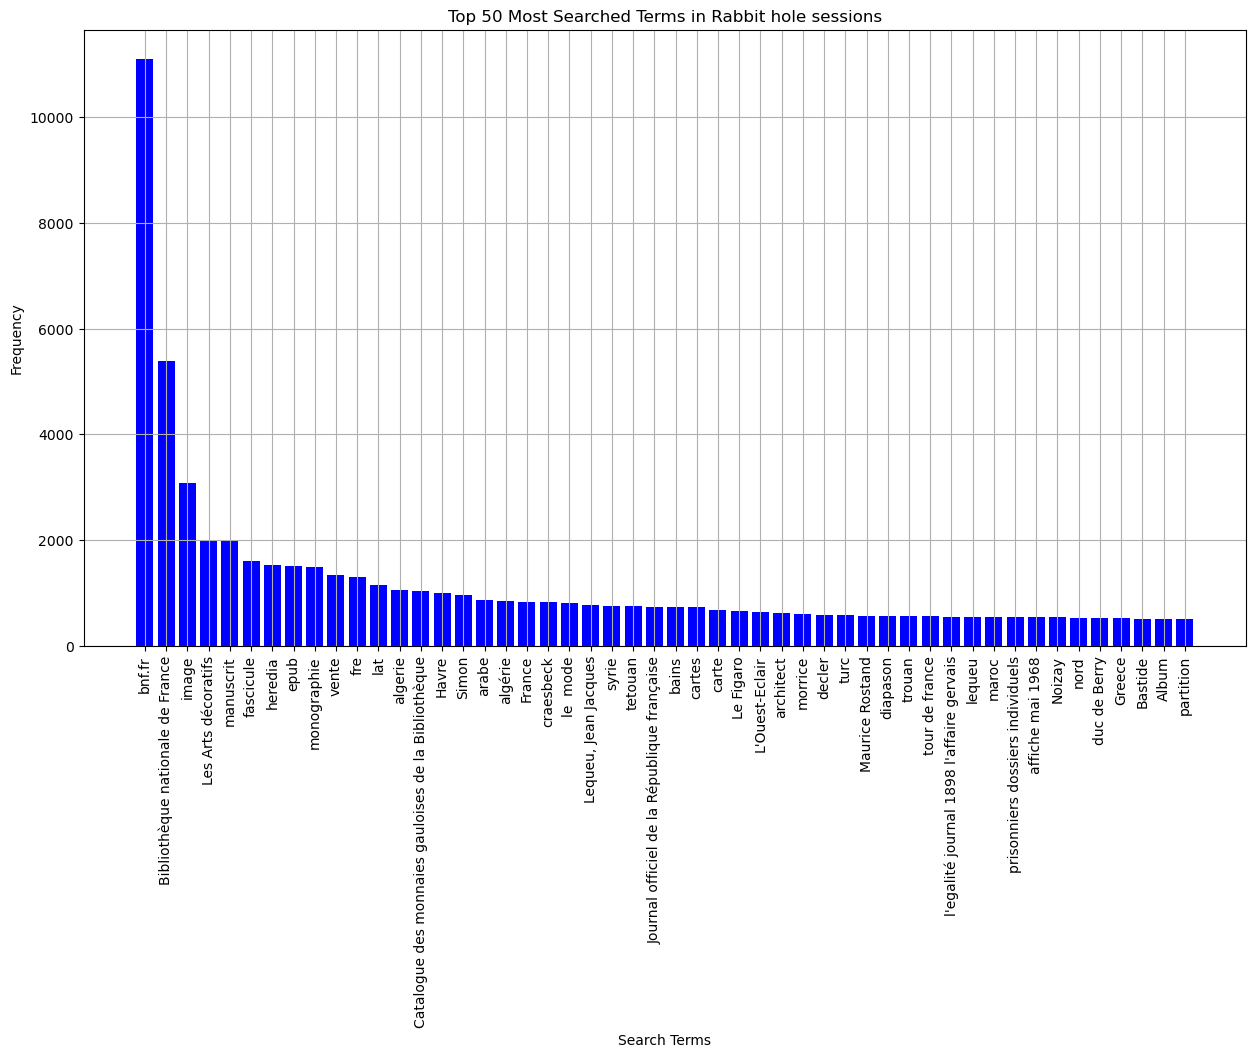

In [177]:
# count the frequency of each search term
term_counts = collections.Counter(flat_search_terms)

# get the 50 most frequent search terms
top_50_terms = term_counts.most_common(50)

# separate the terms and their counts for plotting
terms, counts = zip(*top_50_terms)

# visualize the results using a bar chart
plt.figure(figsize=(15, 8))
plt.bar(terms, counts, color='blue')
plt.xlabel('Search Terms')
plt.ylabel('Frequency')
plt.title('Top 50 Most Searched Terms in Rabbit hole sessions')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig("plots/top50search_rh.png")
plt.show()

We look at the correlation between the length of a sessions and the mean / min visibility.

In [59]:
# correlation
# Compute correlation between 'length_session' and 'mean_visibility'
correlation_length_meanvisibility = sessions_normal_df[['length_minutes', 'mean_visibility']].corr().iloc[0, 1]

# Compute correlation between 'min_visibility' and 'length_session'
correlation_minvisibility_length = sessions_normal_df[['min_visibility', 'length_minutes']].corr().iloc[0, 1]

# Show the computed correlations
print("For sessions:")
print("Correlation between length_session and mean_visibility:", correlation_length_meanvisibility)
print("Correlation between min_visibility and length_session:", correlation_minvisibility_length)


For sessions:
Correlation between length_session and mean_visibility: 0.0026757673020918805
Correlation between min_visibility and length_session: -0.0004994658235858029


In [181]:
# correlation
# Compute correlation between 'length_session' and 'mean_visibility'
correlation_length_meanvisibility = sessions_rh_df[['length_minutes', 'mean_visibility']].corr().iloc[0, 1]

# Compute correlation between 'min_visibility' and 'length_session'
correlation_minvisibility_length = sessions_rh_df[['min_visibility', 'length_minutes']].corr().iloc[0, 1]

# Show the computed correlations
print("For RH sessions:")
print("Correlation between length_session and mean_visibility:", correlation_length_meanvisibility)
print("Correlation between min_visibility and length_session:", correlation_minvisibility_length)


For RH sessions:
Correlation between length_session and mean_visibility: -0.035757640840427096
Correlation between min_visibility and length_session: -0.010880956087188155


These correlations are not significant, but they are slightly higher for rabbit hole sessions.

In [62]:
def extract_first_date(date_str):
    try:
        # split the string to get the first date, remove extra characters
        first_date_str = date_str.split(',')[0].strip("[] '\"")
        # convert to datetime
        first_date = pd.to_datetime(first_date_str)
        return first_date
    except Exception as e:
        return pd.NaT

In [63]:
# get first date of the sessions to find and plot hour, day of the week
sessions_df['first_date'] = sessions_df['Date'].apply(extract_first_date)
sessions_rh_df['first_date'] = sessions_rh_df['Date'].apply(extract_first_date)


In [64]:
def get_day_name(date):
    try:
        first_date = pd.to_datetime(date)
        return first_date.day_name()
    except (ValueError, IndexError):
        return 'Invalid Date'

In [65]:
# statistics day of the week beg. of sessions
sessions_df['day_beginning'] = sessions_df['first_date'].dt.day_name()
sessions_rh_df['day_beginning'] = sessions_rh_df['first_date'].dt.day_name()


In [94]:
sessions_normal_df.loc[:, 'first_date'] = sessions_normal_df['Date'].apply(extract_first_date)
sessions_normal_df.loc[:, 'day_beginning'] = sessions_normal_df['first_date'].dt.day_name()


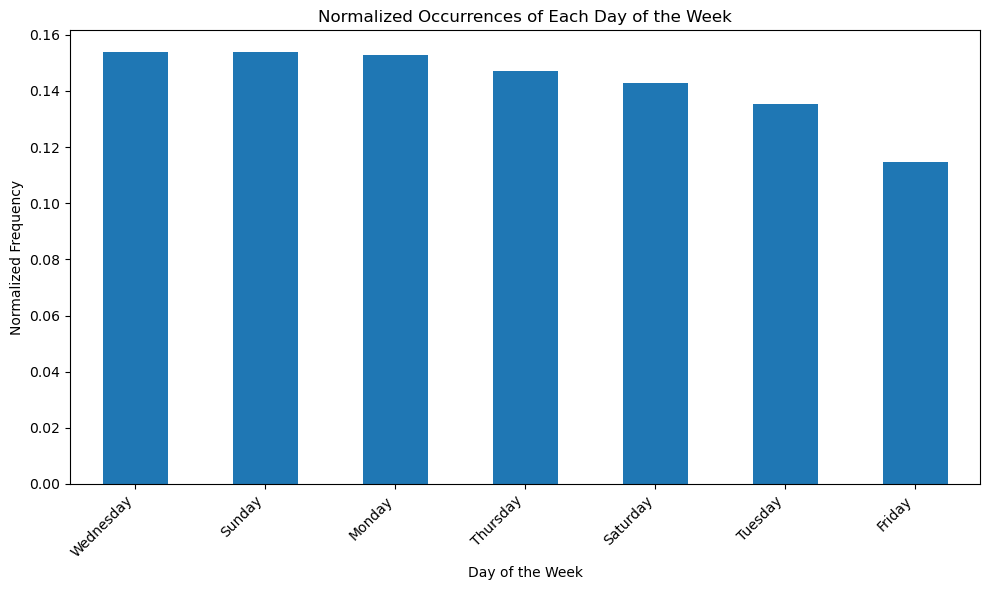

In [267]:
# Count occurrences of each day of the week
day_counts = sessions_normal_df['day_beginning'].value_counts()
total_sessions = day_counts.sum()
normalized_day_counts = day_counts / total_sessions
# Plot the occurrences
plt.figure(figsize=(10, 6))
normalized_day_counts.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Occurrences of Each Day of the Week')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/day_week.png", bbox_inches='tight')
plt.show()

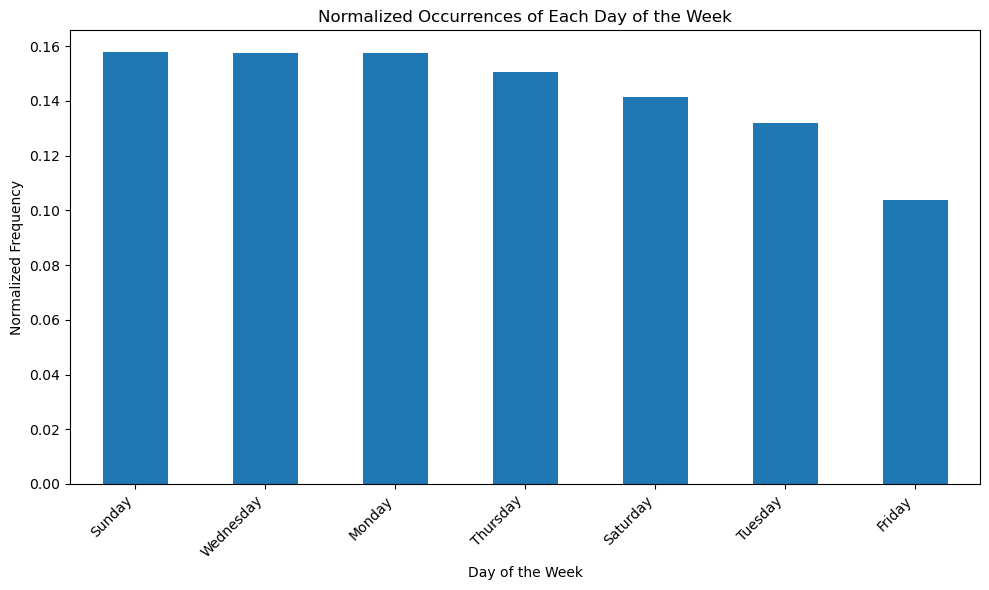

In [268]:
# Count occurrences of each day of the week
day_counts = sessions_rh_df['day_beginning'].value_counts()
total_sessions = day_counts.sum()
normalized_day_counts = day_counts / total_sessions
# Plot the occurrences
plt.figure(figsize=(10, 6))
normalized_day_counts.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Occurrences of Each Day of the Week')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/day_week_rh.png", bbox_inches='tight')
plt.show()

Find the common first referrers

In [87]:
def group_referrer(referrer):
    if pd.isna(referrer):
        return referrer
    if 'google' in referrer:
        return 'google'
    elif 'bing' in referrer:
        return 'bing'
    elif 'facebook' in referrer:
        return 'facebook'
    return referrer

In [89]:
sessions_normal_df.loc[:, 'grouped_referrer'] = sessions_normal_df['first_referrer'].apply(group_referrer)
sessions_rh_df.loc[:, 'grouped_referrer'] = sessions_rh_df['first_referrer'].apply(group_referrer)

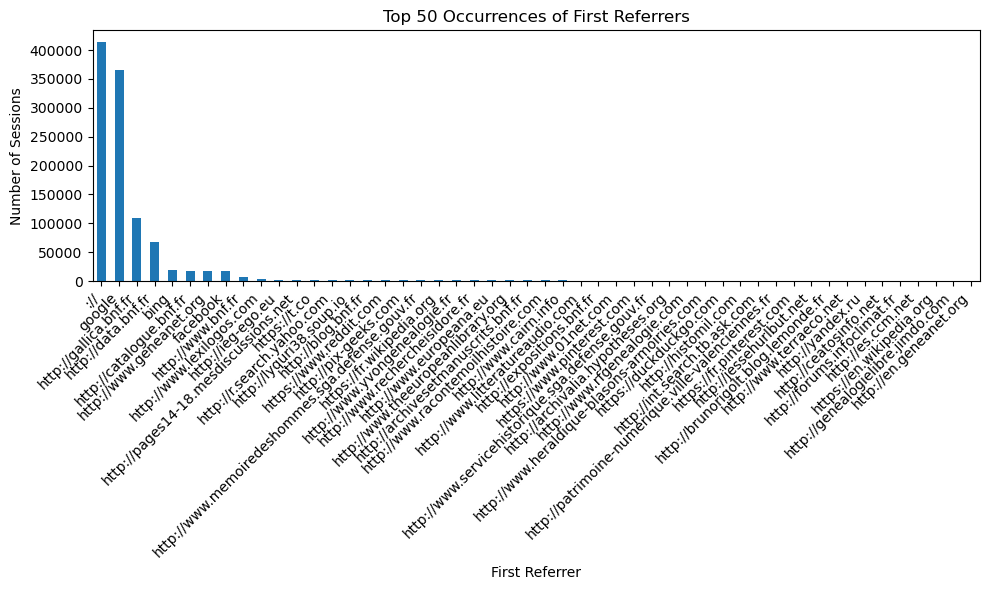

In [265]:
# statistics on the referrers
# Plot the referrer counts
referrer_counts = sessions_normal_df['grouped_referrer'].value_counts()

# Select the top 50 referrers
top_50_referrers = referrer_counts.head(50)

# Plot the top 50 referrer counts
plt.figure(figsize=(10, 6))
top_50_referrers.plot(kind='bar')
plt.xlabel('First Referrer')
plt.ylabel('Number of Sessions')
plt.title('Top 50 Occurrences of First Referrers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/referrer.png", bbox_inches='tight')
plt.show()

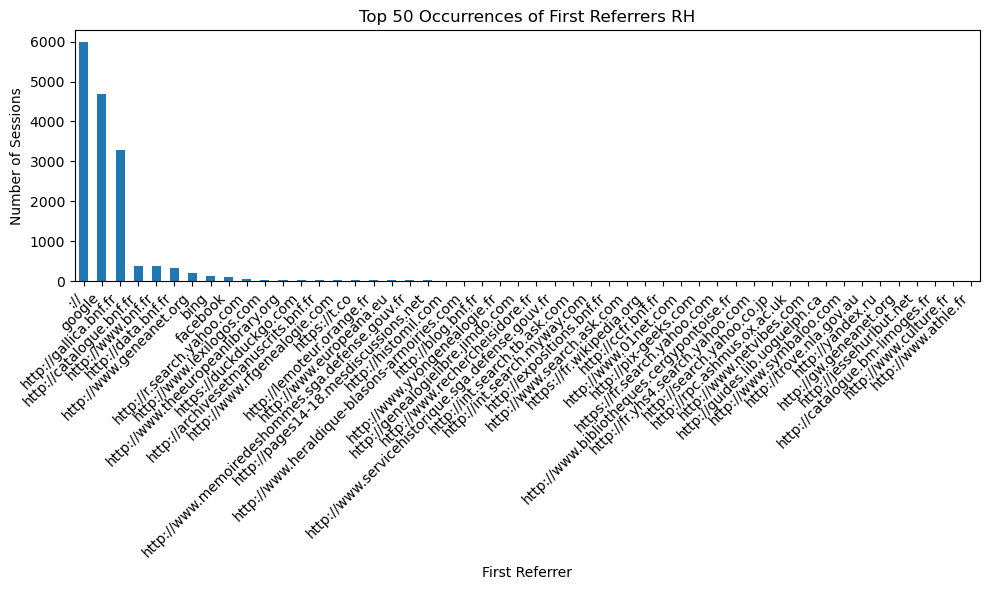

In [266]:
referrer_counts = sessions_rh_df['grouped_referrer'].value_counts()

# Select the top 50 referrers
top_50_referrers = referrer_counts.head(50)

# Plot the top 50 referrer counts
plt.figure(figsize=(10, 6))
top_50_referrers.plot(kind='bar')
plt.xlabel('First Referrer')
plt.ylabel('Number of Sessions')
plt.title('Top 50 Occurrences of First Referrers RH')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/referrer_rh.png", bbox_inches='tight')
plt.show()

In [72]:
# function to find the hour the session began at
def extract_hour(date_time):
    return pd.to_datetime(date_time).hour


In [74]:
sessions_normal_df.reset_index(drop=True, inplace=True)
sessions_normal_df.loc[:, 'hour'] = sessions_normal_df['first_date'].apply(lambda x: extract_hour(x))
sessions_rh_df.reset_index(drop=True, inplace=True)
sessions_rh_df.loc[:, 'hour'] = sessions_rh_df['first_date'].apply(lambda x: extract_hour(x))

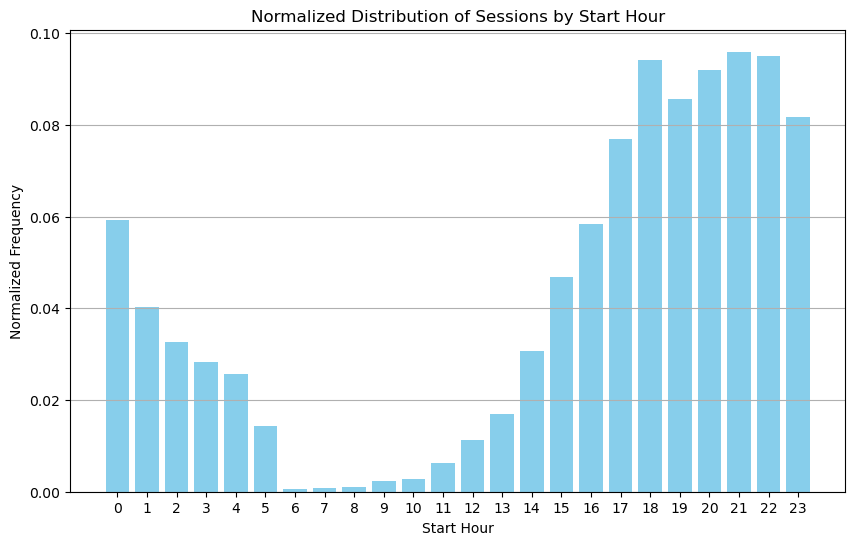

In [270]:
# Calculate the counts for each start hour
hour_counts = sessions_normal_df['hour'].value_counts().sort_index()
total_sessions = hour_counts.sum()
normalized_hour_counts = hour_counts / total_sessions
# Plot the distribution of start hours
plt.figure(figsize=(10, 6))
plt.bar(normalized_hour_counts.index, normalized_hour_counts.values, color='skyblue')
plt.xlabel('Start Hour')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Distribution of Sessions by Start Hour')
plt.xticks(range(24))
plt.grid(axis='y')
plt.savefig("plots/hours.png", bbox_inches='tight')
plt.show()

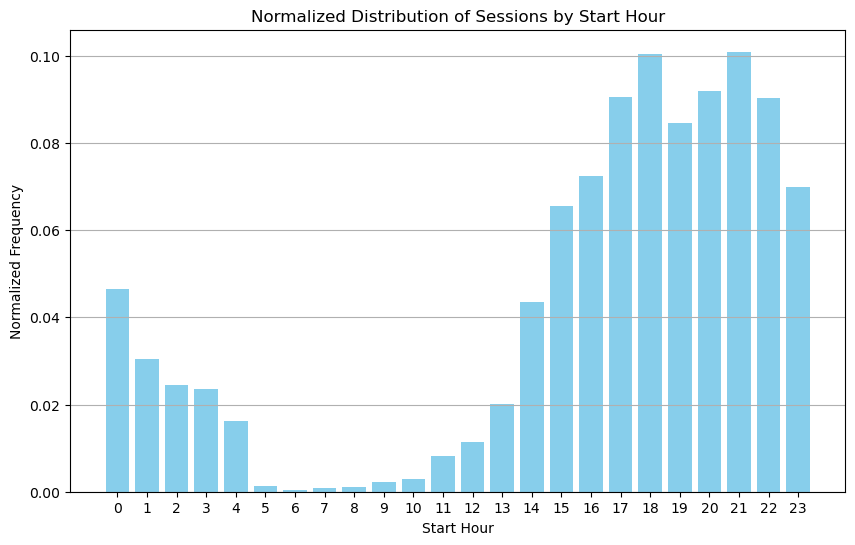

In [271]:
# Calculate the counts for each start hour
hour_counts = sessions_rh_df['hour'].value_counts().sort_index()
total_sessions = hour_counts.sum()
normalized_hour_counts = hour_counts / total_sessions
# Plot the distribution of start hours
plt.figure(figsize=(10, 6))
plt.bar(normalized_hour_counts.index, normalized_hour_counts.values, color='skyblue')
plt.xlabel('Start Hour')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Distribution of Sessions by Start Hour')
plt.xticks(range(24))
plt.grid(axis='y')
plt.savefig("plots/hours_rh.png", bbox_inches='tight')
plt.show()

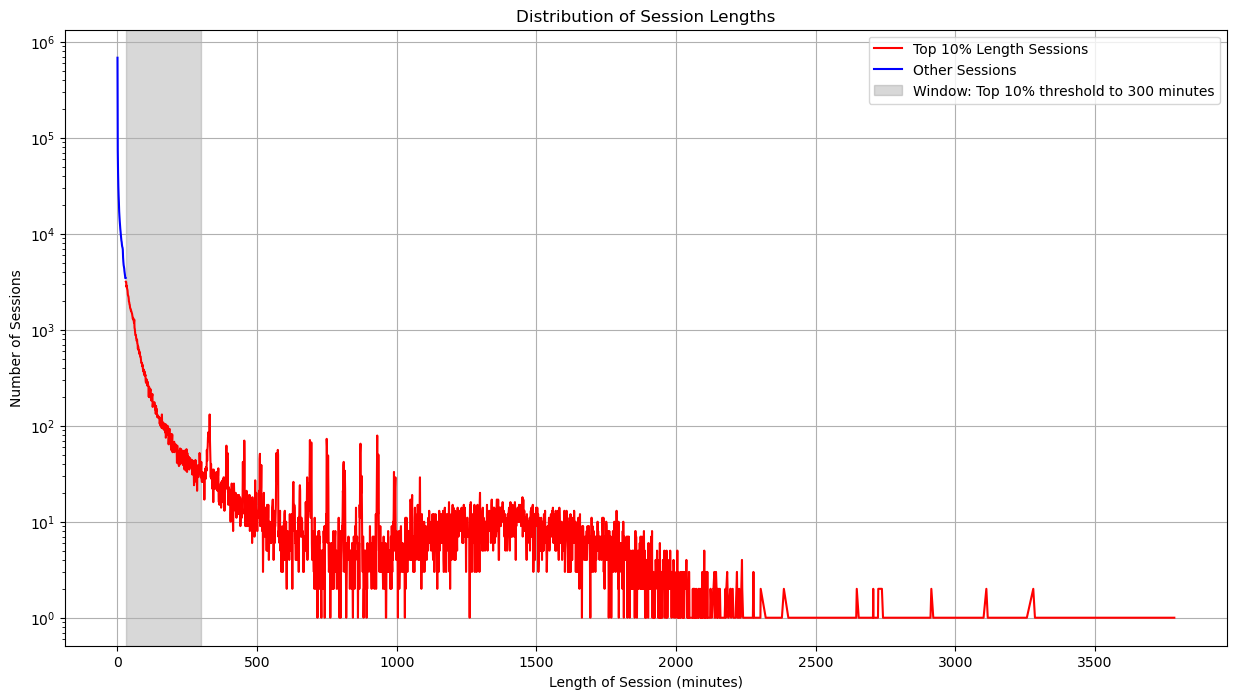

In [245]:
# Separate sessions into top 10% and not in top 10%
top_10_sessions = sessions_df[sessions_df['top_10%_length']]
other_sessions = sessions_df[~sessions_df['top_10%_length']]

# Calculate session lengths count for top 10% and other sessions
top_10_length_count = top_10_sessions['length_minutes'].value_counts().sort_index()
other_length_count = other_sessions['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot top 10% sessions
plt.plot(top_10_length_count.index, top_10_length_count.values, linestyle='-', color='red', label='Top 10% Length Sessions')

# Plot other sessions
plt.plot(other_length_count.index, other_length_count.values, linestyle='-', color='blue', label='Other Sessions')

# Highlight the area between the top 10% threshold and 300 minutes
top_10_threshold = top_10_sessions['length_minutes'].min()
plt.axvspan(top_10_threshold, 300, color='gray', alpha=0.3, label='Window: Top 10% threshold to 300 minutes')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Lengths')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.savefig("plots/sess_length_all.png", bbox_inches='tight')
plt.show()


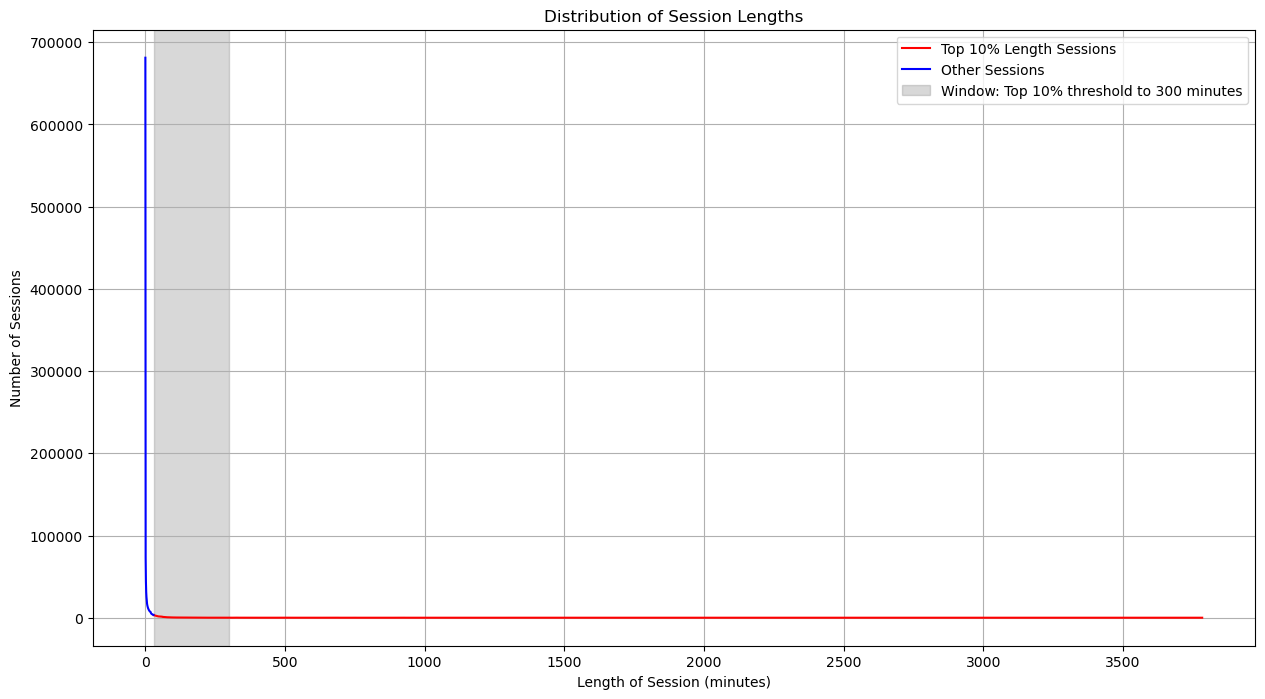

In [246]:
# Separate sessions into top 10% and not in top 10%
top_10_sessions = sessions_df[sessions_df['top_10%_length']]
other_sessions = sessions_df[~sessions_df['top_10%_length']]

# Calculate session lengths count for top 10% and other sessions
top_10_length_count = top_10_sessions['length_minutes'].value_counts().sort_index()
other_length_count = other_sessions['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot top 10% sessions
plt.plot(top_10_length_count.index, top_10_length_count.values, linestyle='-', color='red', label='Top 10% Length Sessions')

# Plot other sessions
plt.plot(other_length_count.index, other_length_count.values, linestyle='-', color='blue', label='Other Sessions')

# Highlight the area between the top 10% threshold and 300 minutes
top_10_threshold = top_10_sessions['length_minutes'].min()
plt.axvspan(top_10_threshold, 300, color='gray', alpha=0.3, label='Window: Top 10% threshold to 300 minutes')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Lengths')
plt.grid(True)
plt.legend()
plt.savefig("plots/sess_length_all_not_log.png", bbox_inches='tight')
plt.show()


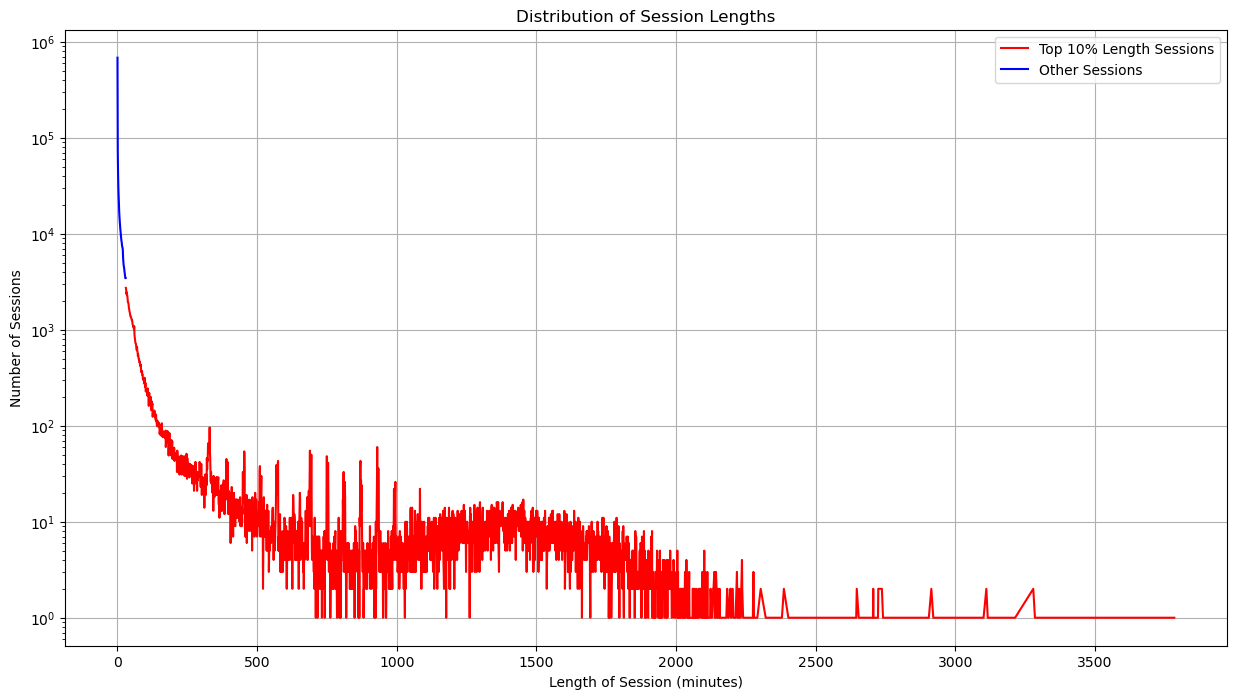

In [248]:
# Separate sessions into top 10%, other sessions, and very long sessions
top_10_sessions = sessions_normal_df[sessions_normal_df['top_10%_length']]
other_sessions = sessions_normal_df[~sessions_normal_df['top_10%_length']]

# Calculate session lengths count for top 10%, other sessions, and very long sessions
top_10_length_count = top_10_sessions['length_minutes'].value_counts().sort_index()
other_length_count = other_sessions['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot top 10% sessions
plt.plot(top_10_length_count.index, top_10_length_count.values, linestyle='-', color='red', label='Top 10% Length Sessions')

# Plot other sessions
plt.plot(other_length_count.index, other_length_count.values, linestyle='-', color='blue', label='Other Sessions')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Lengths')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.savefig("plots/sess_length.png", bbox_inches='tight')
plt.show()

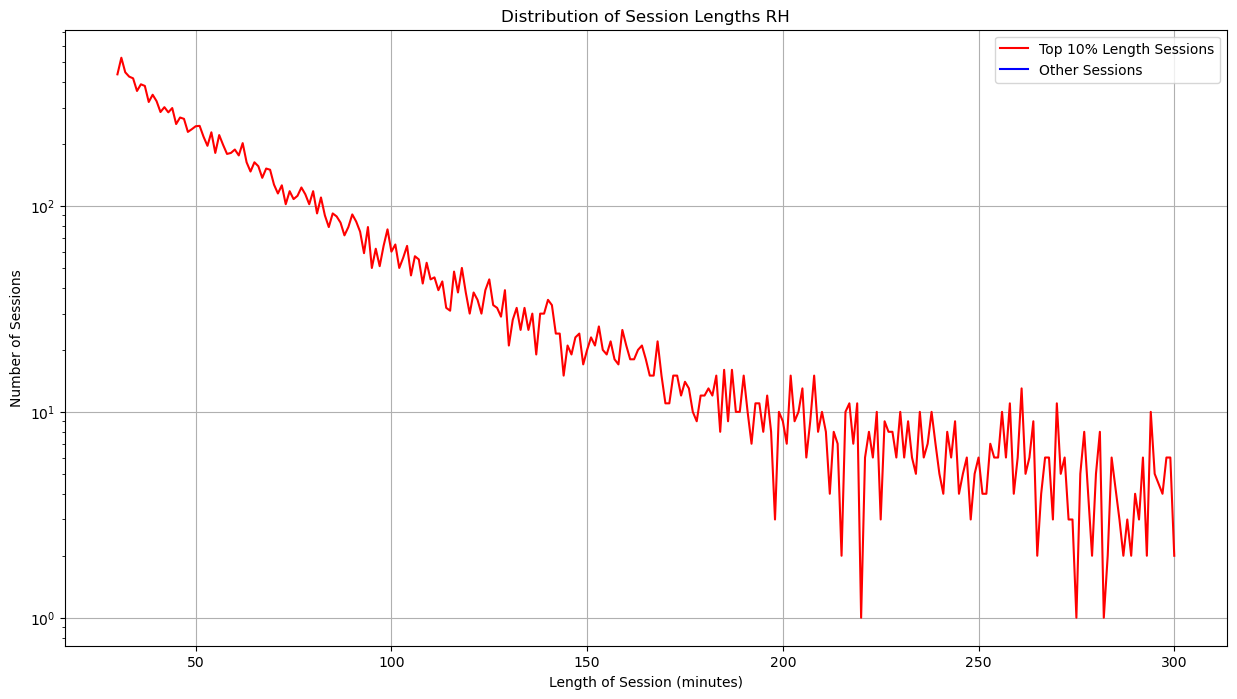

In [249]:
# Separate sessions into top 10% and not in top 10%
top_10_sessions = sessions_rh_df[sessions_rh_df['top_10%_length']]
other_sessions = sessions_rh_df[~sessions_rh_df['top_10%_length']]

# Calculate session lengths count for top 10% and other sessions
top_10_length_count = top_10_sessions['length_minutes'].value_counts().sort_index()
other_length_count = other_sessions['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot top 10% sessions
plt.plot(top_10_length_count.index, top_10_length_count.values, linestyle='-', color='red', label='Top 10% Length Sessions')

# Plot other sessions
plt.plot(other_length_count.index, other_length_count.values, linestyle='-', color='blue', label='Other Sessions')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Lengths RH')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.savefig("plots/sess_length_rh.png", bbox_inches='tight')
plt.show()


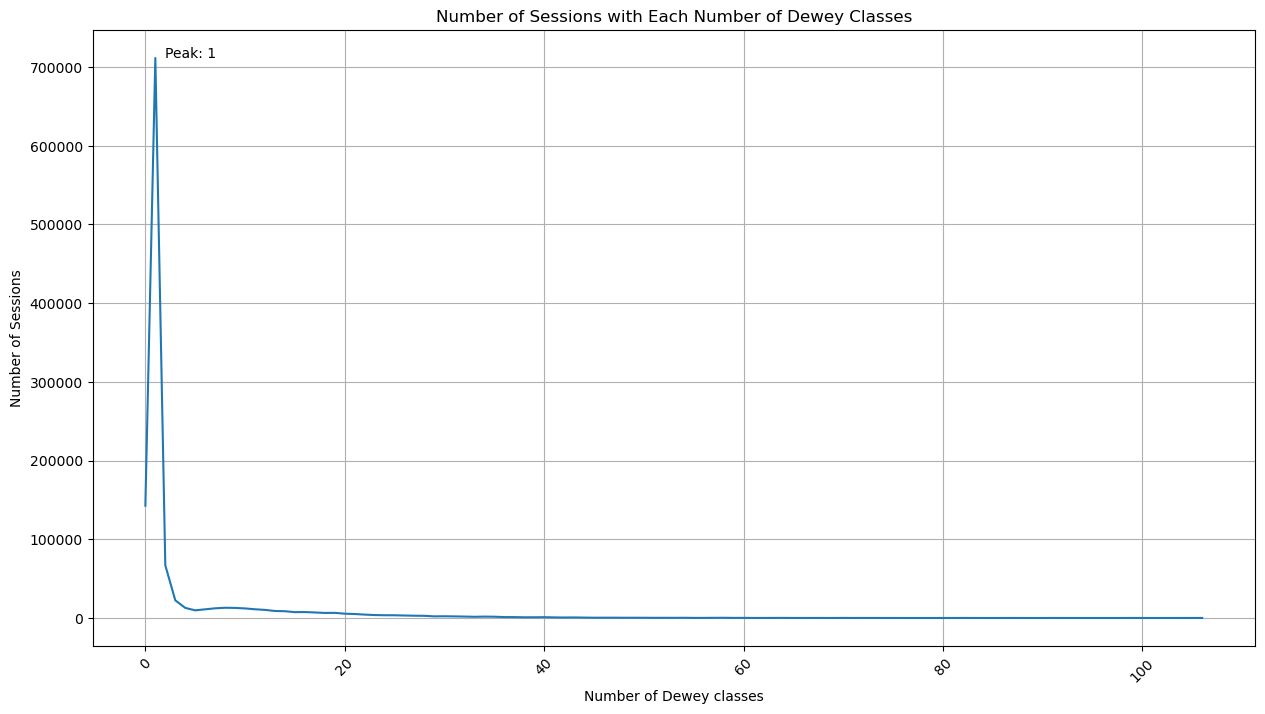

Peak value occurs at: 1


In [250]:
dewey_classes_counts = sessions_normal_df['nb_themes'].value_counts().sort_index()

# Find the peak value
peak_value = dewey_classes_counts.idxmax()

plt.figure(figsize=(15, 8))
plt.plot(dewey_classes_counts.index, dewey_classes_counts.values, linestyle='-')
plt.xlabel('Number of Dewey classes')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of Dewey Classes')
plt.grid(True)
plt.xticks(rotation=45)

# Add annotation for the peak value
plt.annotate(f'Peak: {peak_value}', xy=(peak_value, dewey_classes_counts.max()), xytext=(peak_value + 1, dewey_classes_counts.max() - 50))

plt.savefig("plots/nb_themes_with_peak.png", bbox_inches='tight')
plt.show()

print("Peak value occurs at:", peak_value)


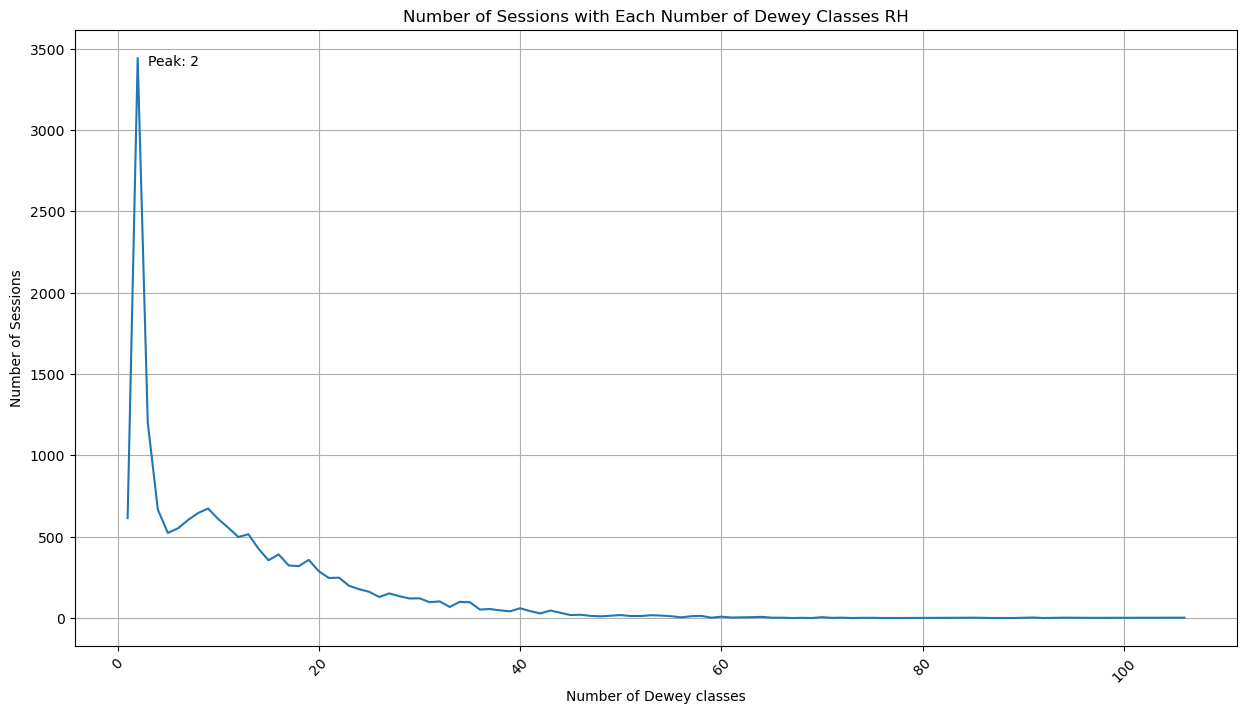

Peak value occurs at: 2


In [251]:
dewey_classes_counts = sessions_rh_df['nb_themes'].value_counts().sort_index()

# Find the peak value
peak_value = dewey_classes_counts.idxmax()

plt.figure(figsize=(15, 8))
plt.plot(dewey_classes_counts.index, dewey_classes_counts.values, linestyle='-')
plt.xlabel('Number of Dewey classes')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of Dewey Classes RH')
plt.grid(True)
plt.xticks(rotation=45)

# Add annotation for the peak value
plt.annotate(f'Peak: {peak_value}', xy=(peak_value, dewey_classes_counts.max()), xytext=(peak_value + 1, dewey_classes_counts.max() - 50))

plt.savefig("plots/nb_themes_with_peak_rh.png", bbox_inches='tight')
plt.show()

print("Peak value occurs at:", peak_value)


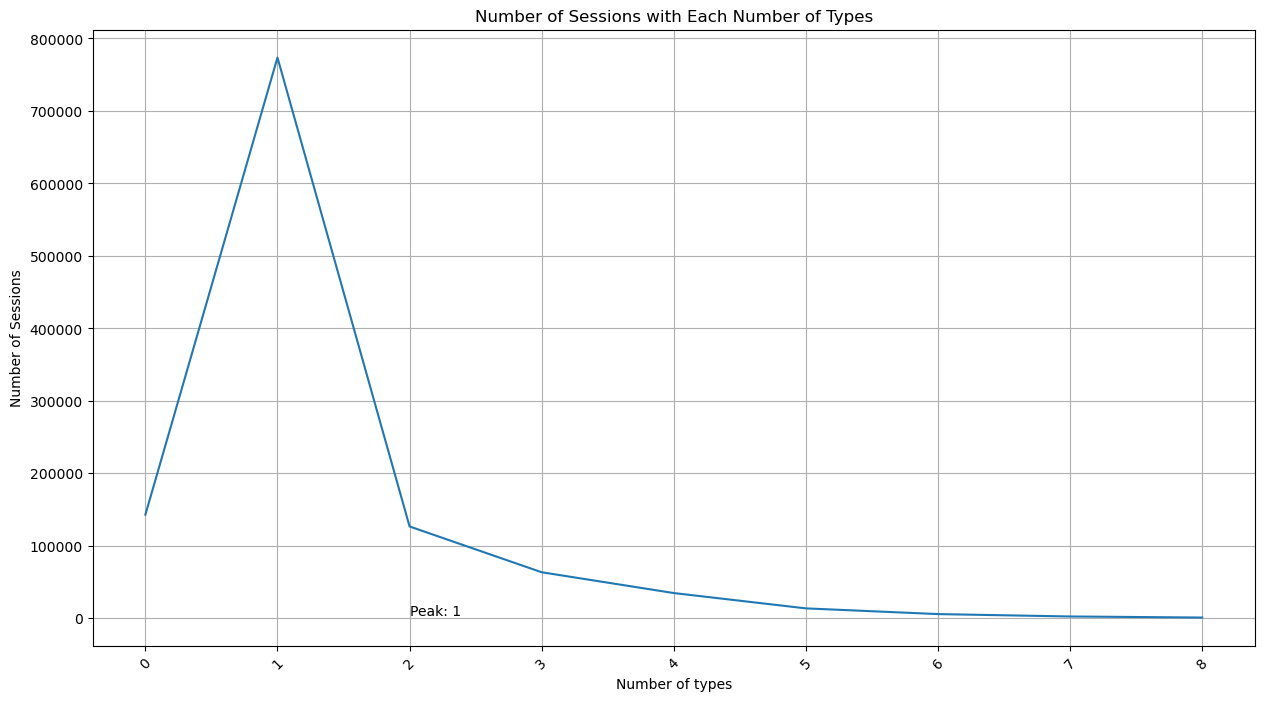

Peak value occurs at: 1


In [123]:
types_counts = sessions_normal_df['nb_types'].value_counts().sort_index()

# Find the peak value
peak_value = types_counts.idxmax()

plt.figure(figsize=(15, 8))
plt.plot(types_counts.index, types_counts.values, linestyle='-')
plt.xlabel('Number of types')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of Types')
plt.grid(True)
plt.xticks(rotation=45)

# Add annotation for the peak value
plt.annotate(f'Peak: {peak_value}', xy=(peak_value, types_counts.max()), xytext=(peak_value + 1, dewey_classes_counts.max() - 50))

plt.savefig("plots/nb_types_with_peak.png")
plt.show()

print("Peak value occurs at:", peak_value)


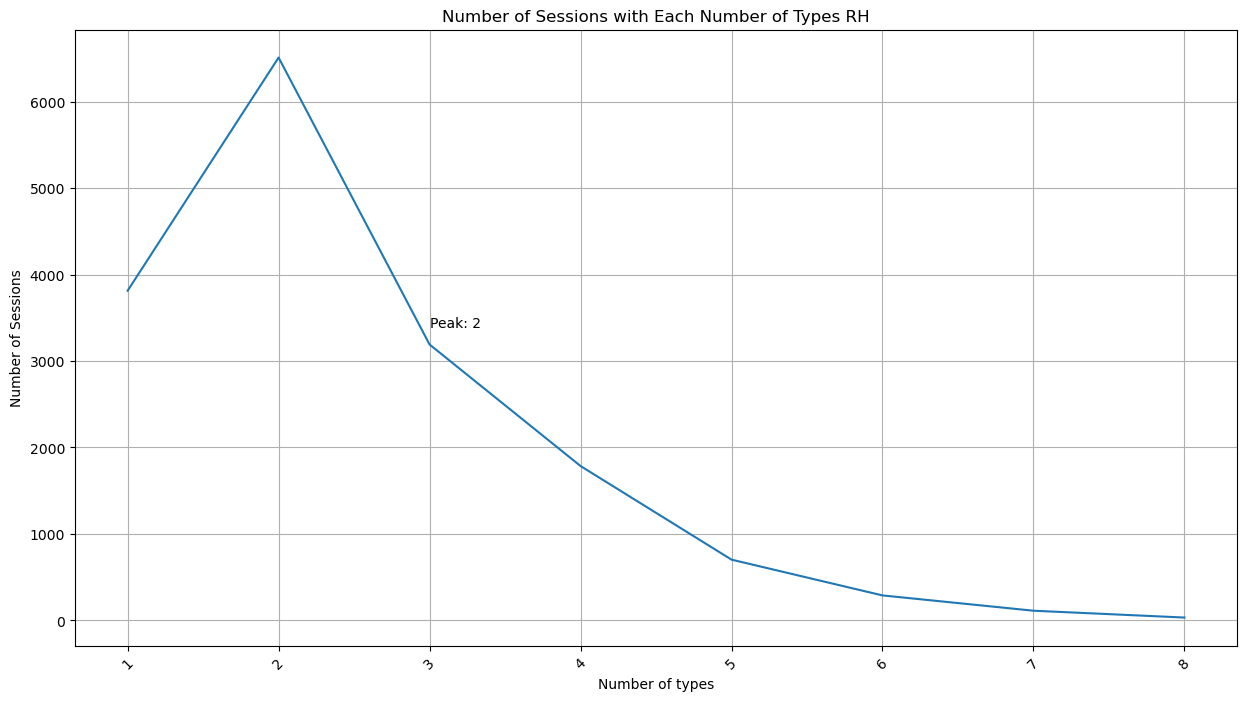

Peak value occurs at: 2


In [252]:
types_counts = sessions_rh_df['nb_types'].value_counts().sort_index()

# Find the peak value
peak_value = types_counts.idxmax()

plt.figure(figsize=(15, 8))
plt.plot(types_counts.index, types_counts.values, linestyle='-')
plt.xlabel('Number of types')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of Types RH')
plt.grid(True)
plt.xticks(rotation=45)

# Add annotation for the peak value
plt.annotate(f'Peak: {peak_value}', xy=(peak_value, types_counts.max()), xytext=(peak_value + 1, dewey_classes_counts.max() - 50))

plt.savefig("plots/nb_types_with_peak_rh.png", bbox_inches='tight')
plt.show()

print("Peak value occurs at:", peak_value)

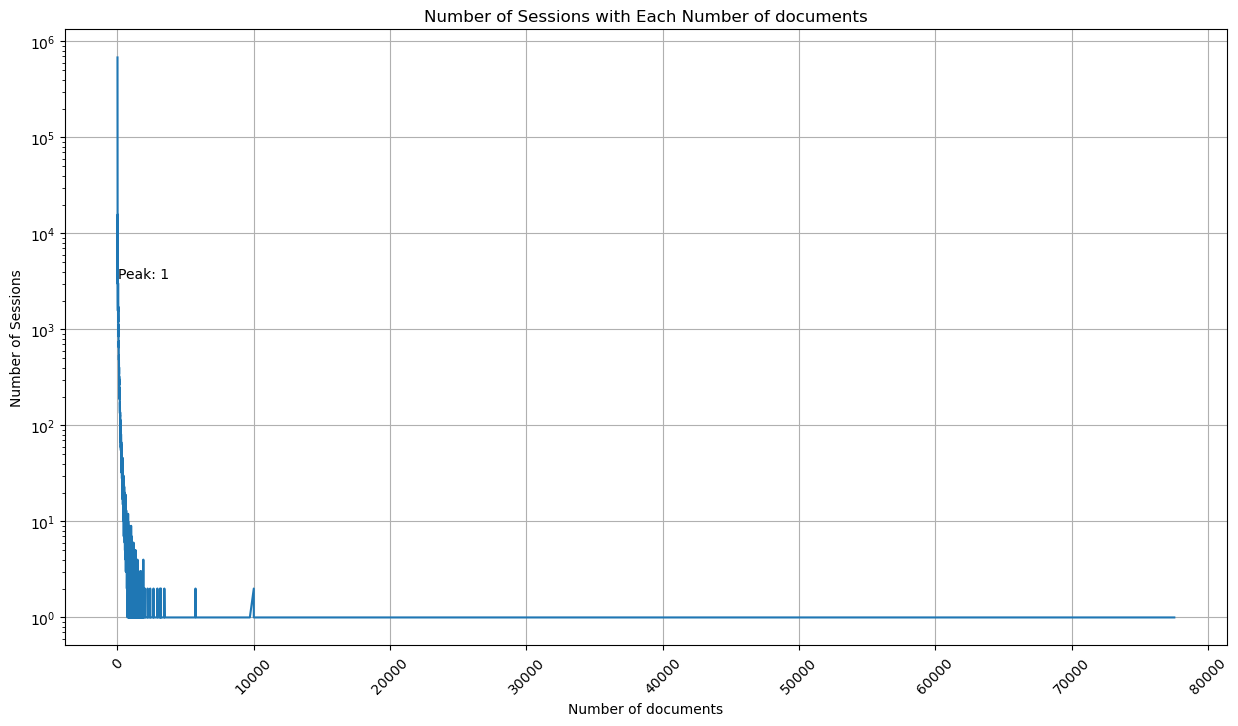

Peak value occurs at: 1


In [253]:
docs_counts = sessions_normal_df['nb_docs'].value_counts().sort_index()

# Find the peak value
peak_value = docs_counts.idxmax()

plt.figure(figsize=(15, 8))
plt.plot(docs_counts.index, docs_counts.values, linestyle='-')
plt.xlabel('Number of documents')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of documents')
plt.grid(True)
plt.yscale('log')
plt.xticks(rotation=45)

# Add annotation for the peak value
plt.annotate(f'Peak: {peak_value}', xy=(peak_value, docs_counts.max()), xytext=(peak_value + 1, dewey_classes_counts.max() - 50))

plt.savefig("plots/nb_docs_with_peak.png", bbox_inches='tight')
plt.show()

print("Peak value occurs at:", peak_value)

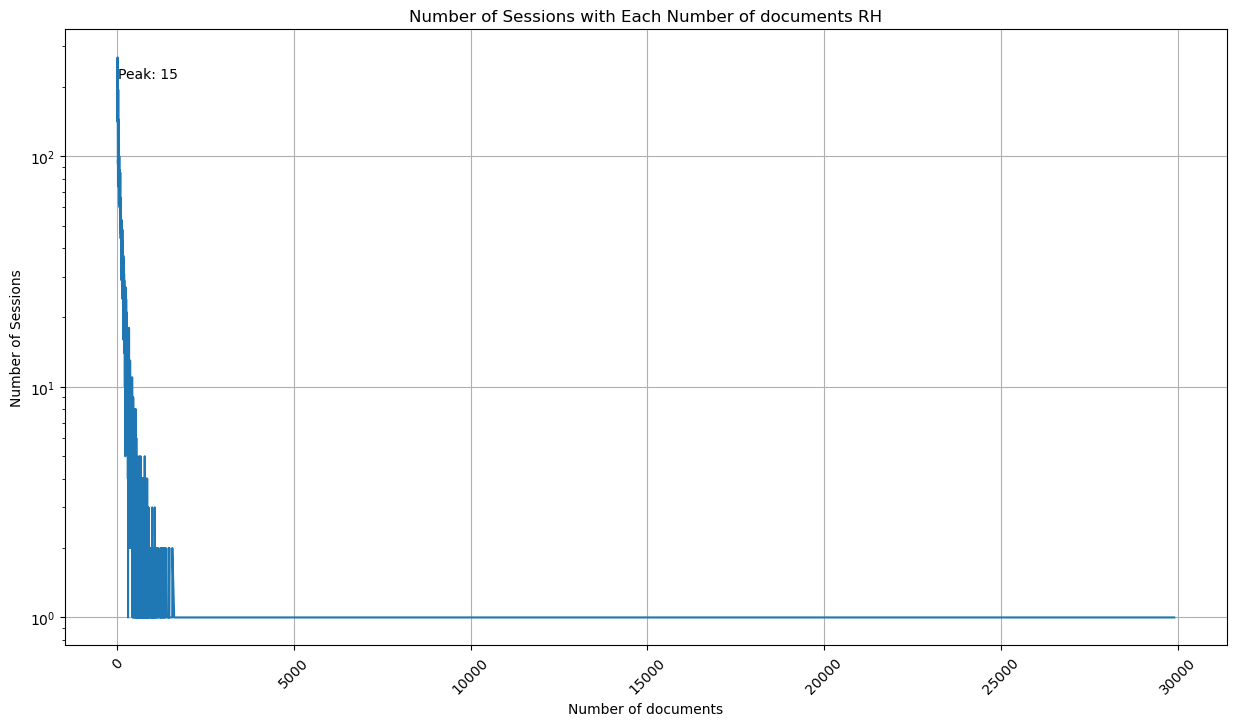

Peak value occurs at: 15


In [254]:
docs_counts = sessions_rh_df['nb_docs'].value_counts().sort_index()

# Find the peak value
peak_value = docs_counts.idxmax()

plt.figure(figsize=(15, 8))
plt.plot(docs_counts.index, docs_counts.values, linestyle='-')
plt.xlabel('Number of documents')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions with Each Number of documents RH')
plt.grid(True)
plt.yscale('log')
plt.xticks(rotation=45)

# Add annotation for the peak value
plt.annotate(f'Peak: {peak_value}', xy=(peak_value, docs_counts.max()), xytext=(peak_value + 1, docs_counts.max() - 50))

plt.savefig("plots/nb_docs_with_peak_rh.png", bbox_inches='tight')
plt.show()

print("Peak value occurs at:", peak_value)


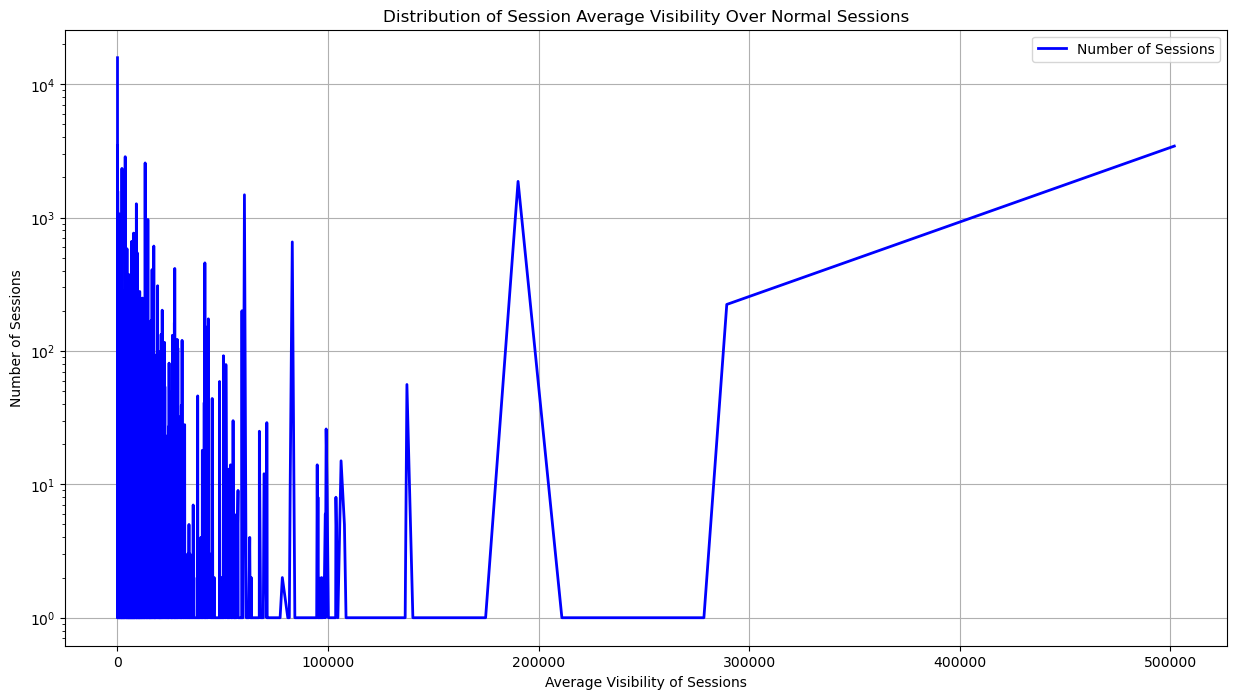

In [255]:
avg_vis = sessions_normal_df['mean_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, linestyle='-', linewidth=2, color='blue', label='Number of Sessions')

plt.xlabel('Average Visibility of Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Average Visibility Over Normal Sessions')
plt.grid(True)
plt.yscale('log')

plt.legend()
plt.savefig("plots/avg_vis.png", bbox_inches='tight')
plt.show()

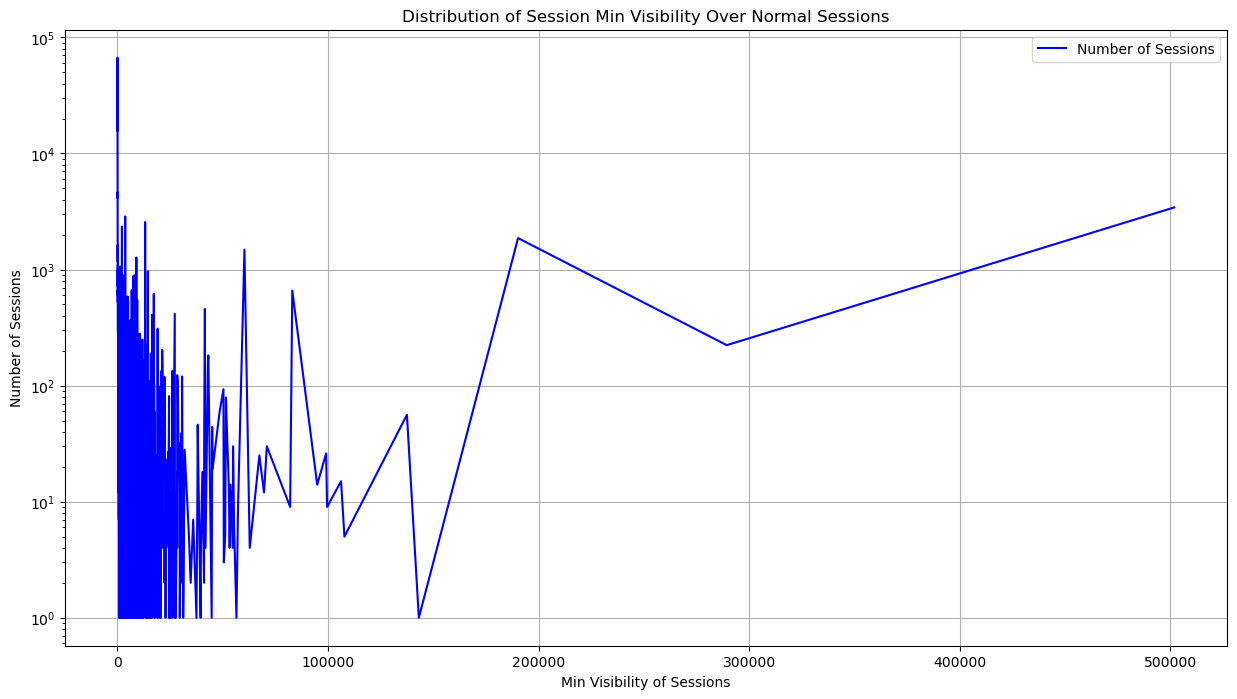

In [256]:
avg_vis = sessions_normal_df['min_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, linestyle='-', color='blue', label='Number of Sessions')

plt.xlabel('Min Visibility of Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Min Visibility Over Normal Sessions')
plt.grid(True)
plt.yscale('log')

plt.legend()
plt.savefig("plots/min_vis.png", bbox_inches='tight')
plt.show()


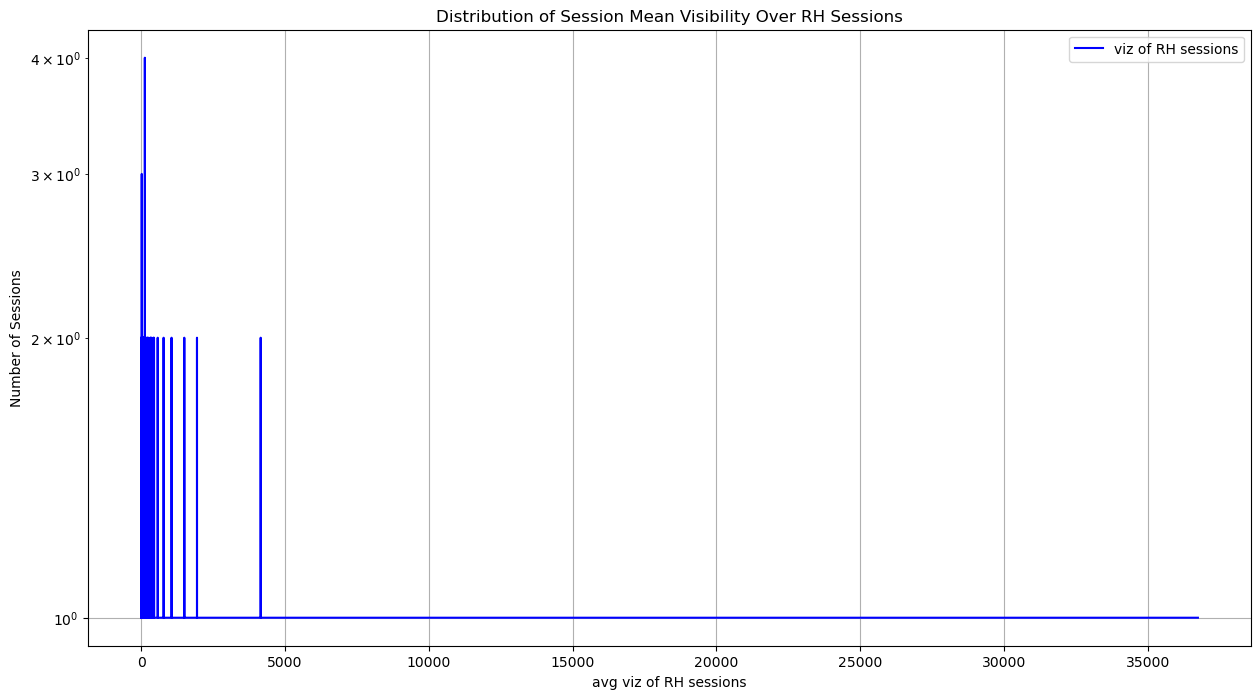

In [257]:

avg_vis = sessions_rh_df['mean_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, linestyle='-', color='blue', label='viz of RH sessions')


plt.xlabel('avg viz of RH sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Mean Visibility Over RH Sessions')
plt.grid(True)
plt.yscale('log')

plt.legend()
plt.savefig("plots/avg_vis_rh.png", bbox_inches='tight')
plt.show()

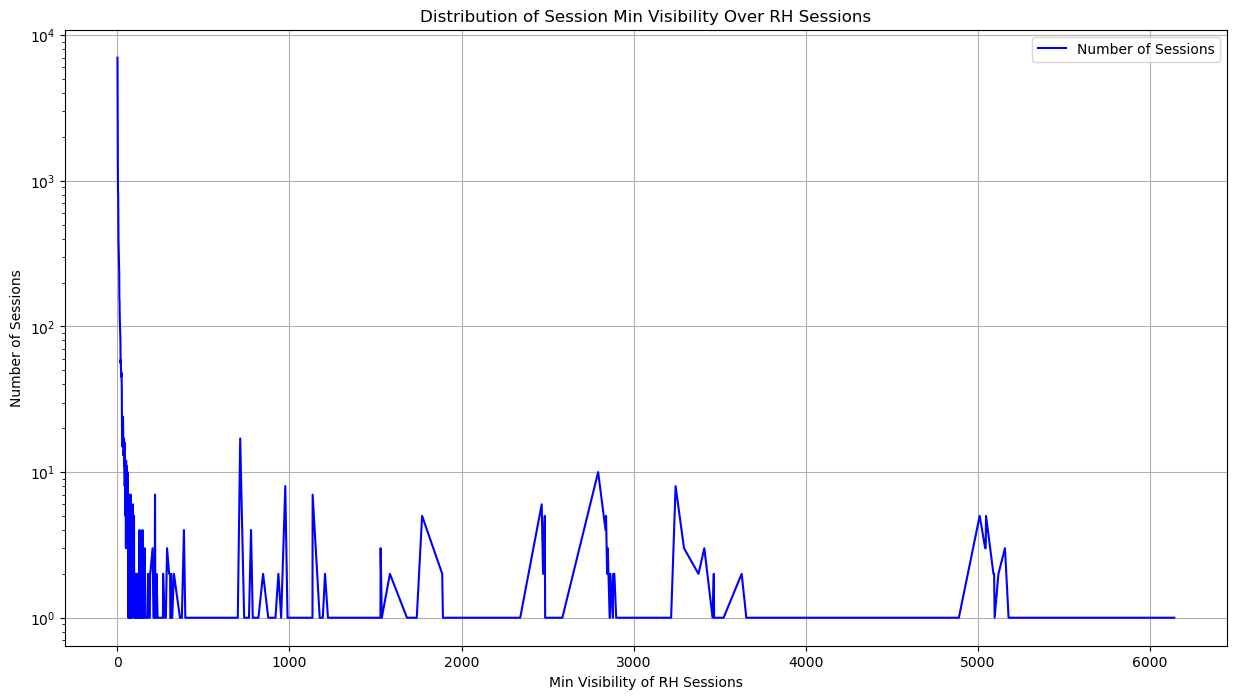

In [258]:
avg_vis = sessions_rh_df['min_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, linestyle='-', color='blue', label='Number of Sessions')

plt.xlabel('Min Visibility of RH Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Min Visibility Over RH Sessions')
plt.grid(True)
plt.yscale('log')

plt.legend()
plt.savefig("plots/min_vis_rh.png", bbox_inches='tight')
plt.show()


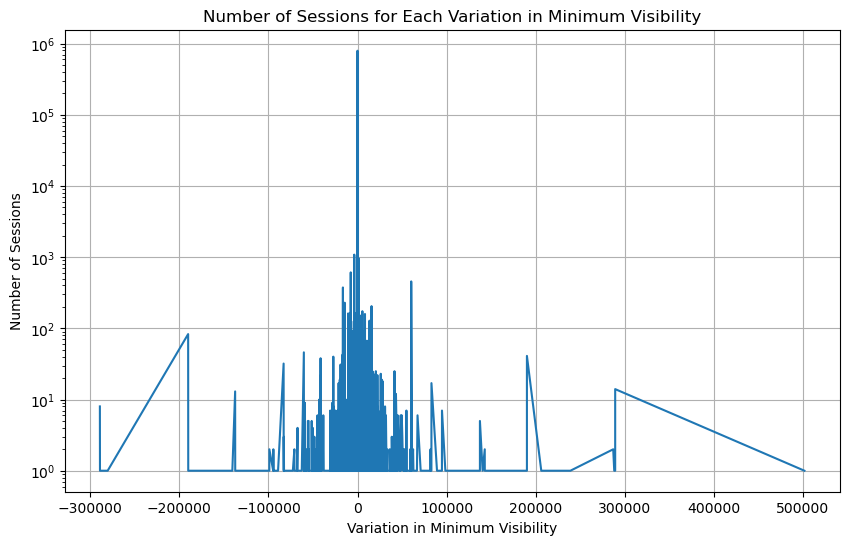

In [259]:
variation_counts = sessions_normal_df['variation_min_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, linestyle='-')
plt.xlabel('Variation in Minimum Visibility')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Minimum Visibility')
plt.grid(True)
plt.yscale('log')

plt.savefig("plots/var_min.png", bbox_inches='tight')
plt.show()

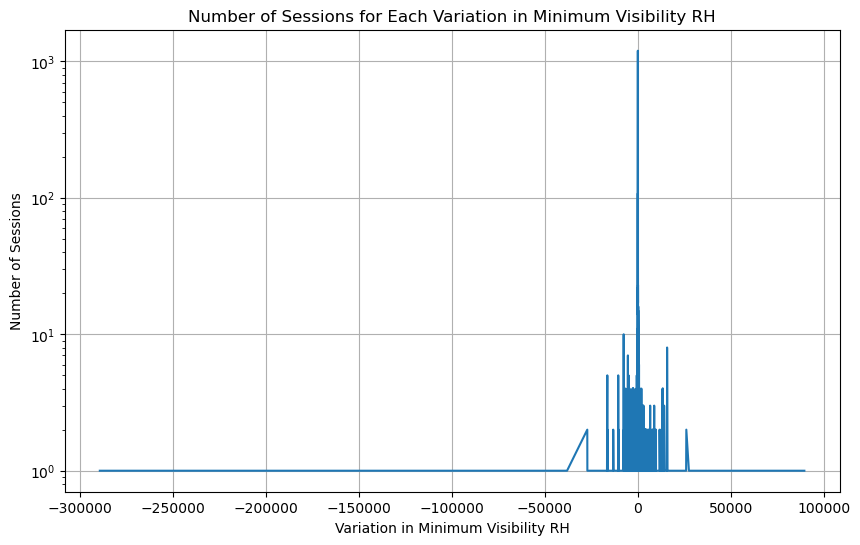

In [260]:
variation_counts = sessions_rh_df['variation_min_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, linestyle='-')
plt.xlabel('Variation in Minimum Visibility RH')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Minimum Visibility RH')
plt.grid(True)
plt.yscale('log')

plt.savefig("plots/var_min_rh.png", bbox_inches='tight')
plt.show()

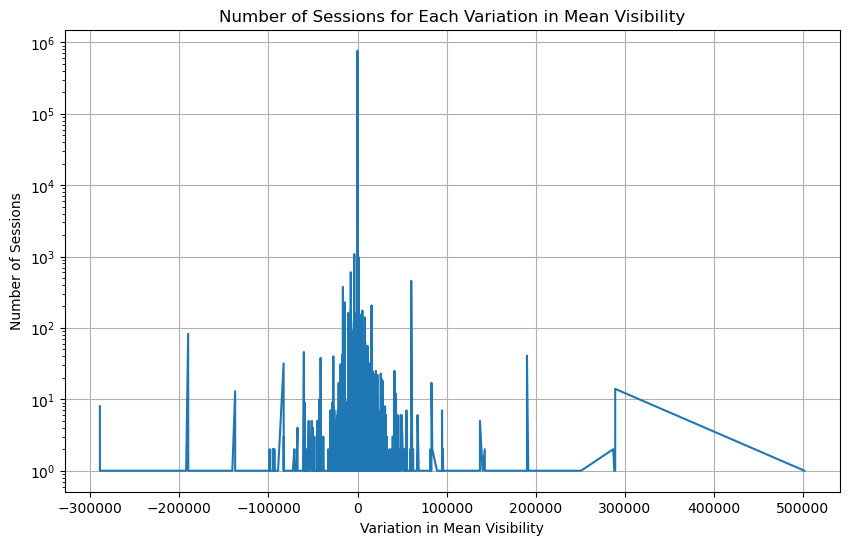

In [261]:
variation_counts = sessions_normal_df['variation_mean_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, linestyle='-')
plt.xlabel('Variation in Mean Visibility')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Mean Visibility')
plt.grid(True)
plt.yscale('log')

plt.savefig("plots/var_mean.png", bbox_inches='tight')
plt.show()

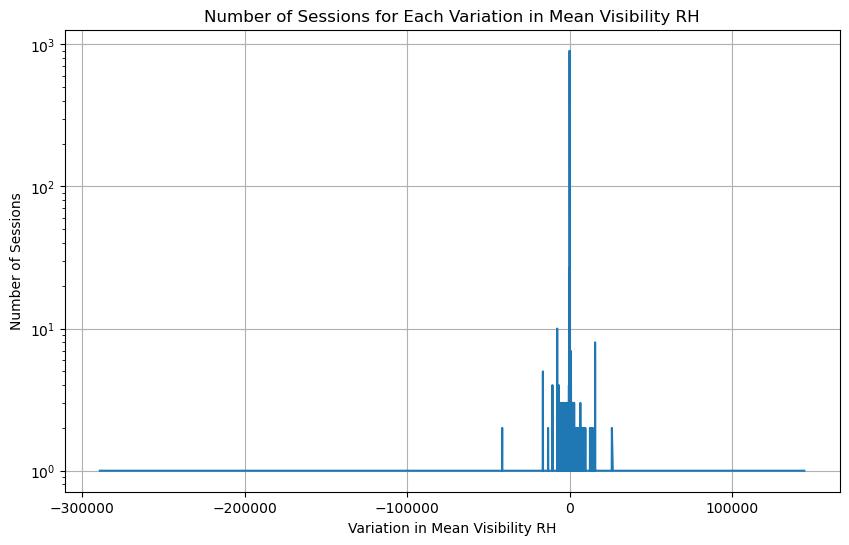

In [262]:
variation_counts = sessions_rh_df['variation_mean_vis'].value_counts().sort_index()

# Plot the number of sessions for each unique value of 'variation_min_vis'
plt.figure(figsize=(10, 6))
plt.plot(variation_counts.index, variation_counts.values, linestyle='-')
plt.xlabel('Variation in Mean Visibility RH')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each Variation in Mean Visibility RH')
plt.grid(True)
plt.yscale('log')

plt.savefig("plots/var_mean_rh.png", bbox_inches='tight')
plt.show()